# Load Data

In [1]:
from pathlib import Path
import sys

# Go up one folder from the current notebook directory
sys.path.append(str(Path().resolve().parent))

from src.data_access import load_housing_data

In [2]:
train, test = load_housing_data()

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

# EDA

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
train_eda = train.copy()

- 1460 instances, 80 features
- data types: mostly int64 and object (text, since loaded from csv), and some float64

In [20]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
X_train = train_eda.drop(columns='SalePrice')
y_train = train_eda['SalePrice']

# Classification of features
Given the large number of features (≈80), I will begin by organizing them into meaningful categories such as nominal, ordinal, skewed, constant, temporal (e.g., years), and others. This classification serves two purposes: it streamlines the EDA process by allowing focused analysis within each group, and it provides a structured foundation for building preprocessing pipelines later on.

My approach would be to mainly write categorization functions, pass the dataframe through them to get candidate sets, and then inspect each group afterward and make manual overrides.

## Numerical Features

We will begin with numerical features, dividing them into three mutually exclusive categories:

- **Continuous** (includes high-cardinality discrete variables): values span a broad range and are treated as measurable quantities. These often require scaling/normalization and may be analyzed for skewness or transformed (e.g., log, Box–Cox).

- **Ordinal**: values have a natural order but unequal or undefined spacing (e.g., quality ratings). These should be encoded with respect to rank (e.g., ordinal encoding), not treated as continuous.

- **Nominal** (numeric disguise): categorical variables stored as numbers (e.g., zip codes, IDs, codes). These require categorical encodings (e.g., one-hot or target encoding) rather than numeric operations.

In addition, overlapping sub-categories such as the following may be defined:

- **Temporal** (e.g., years, months): technically numeric but typically treated as ordered categories or decomposed into features (e.g., age, time since). These are often used to engineer new features rather than modeled directly.

In [59]:
def quick_audit(df, target="SalePrice"):
    s = df.nunique().rename("nunique")
    miss = df.isna().mean().rename("na_rate")
    zero = (df == 0).mean(numeric_only=True).rename("zero_rate")
    out = pd.concat([s, miss, zero], axis=1)
    out['dtype'] = df.dtypes
    if target in df:
        out["corr_num"] = df.select_dtypes("number").corr()[target]
    return out.sort_values(["nunique"], ascending=False)

In [61]:
num_audit = quick_audit(train_eda.select_dtypes(include='number'))
num_audit

nunique   na_rate  zero_rate    dtype  corr_num
Id                1460  0.000000   0.000000    int64 -0.021917
LotArea           1073  0.000000   0.000000    int64  0.263843
GrLivArea          861  0.000000   0.000000    int64  0.708624
BsmtUnfSF          780  0.000000   0.080822    int64  0.214479
1stFlrSF           753  0.000000   0.000000    int64  0.605852
TotalBsmtSF        721  0.000000   0.025342    int64  0.613581
SalePrice          663  0.000000   0.000000    int64  1.000000
BsmtFinSF1         637  0.000000   0.319863    int64  0.386420
GarageArea         441  0.000000   0.055479    int64  0.623431
2ndFlrSF           417  0.000000   0.567808    int64  0.319334
MasVnrArea         327  0.005479   0.589726  float64  0.477493
WoodDeckSF         274  0.000000   0.521233    int64  0.324413
OpenPorchSF        202  0.000000   0.449315    int64  0.315856
BsmtFinSF2         144  0.000000   0.885616    int64 -0.011378
EnclosedPorch      120  0.000000   0.857534    int64 -0.128578
YearBuilt          112  0.000000   0.000000    int64  0.522897
LotFrontage        110  0.177397   0.000000  float64  0.351799
GarageYrBlt         97  0.055479   0.000000  float64  0.486362
ScreenPorch         76  0.000000   0.920548    int64  0.111447
YearRemodAdd        61  0.000000   0.000000    int64  0.507101
LowQualFinSF        24  0.000000   0.982192    int64 -0.025606
MiscVal             21  0.000000   0.964384    int64 -0.021190
3SsnPorch           20  0.000000   0.983562    int64  0.044584
MSSubClass          15  0.000000   0.000000    int64 -0.084284
TotRmsAbvGrd        12  0.000000   0.000000    int64  0.533723
MoSold              12  0.000000   0.000000    int64  0.046432
OverallQual         10  0.000000   0.000000    int64  0.790982
OverallCond          9  0.000000   0.000000    int64 -0.077856
BedroomAbvGr         8  0.000000   0.004110    int64  0.168213
PoolArea             8  0.000000   0.995205    int64  0.092404
GarageCars           5  0.000000   0.055479    int64  0.640409
YrSold               5  0.000000   0.000000    int64 -0.028923
FullBath             4  0.000000   0.006164    int64  0.560664
BsmtFullBath         4  0.000000   0.586301    int64  0.227122
KitchenAbvGr         4  0.000000   0.000685    int64 -0.135907
Fireplaces           4  0.000000   0.472603    int64  0.466929
HalfBath             3  0.000000   0.625342    int64  0.284108
BsmtHalfBath         3  0.000000   0.943836    int64 -0.016844

It can be observed that features naturally divide into two broad groups based on cardinality: those with more than ~25 unique values and those with fewer. Features with high cardinality are more likely to be continuous (or discrete with a wide range), whereas those with low cardinality may represent categorical information. Importantly, within the low-cardinality group, some features that appear numeric may in fact be nominal categories encoded as numbers (e.g., codes, labels). These should be carefully identified and reclassified before analysis and modeling.

In [64]:
low_card_num_cols = num_audit[num_audit['nunique'] < 25].index.tolist()
high_card_num_cols = [c for c in num_audit.index if c not in low_card_num_cols]

### Low Cardinality Numerical Features

To this end, I define a function that visualizes the relationship between each low-cardinality feature and the target variable. The idea is twofold: (i) to inspect the distribution of categories in greater detail (counts, variability), and (ii) to examine how the target behaves across those categories. If a variable is truly ordinal, we should expect to see a monotonic or step-wise trend in the target means across categories. Conversely, if no meaningful order emerges, the feature is likely nominal and should be treated as such.

At the same time, these plots naturally lend themselves to broader classification decisions. Specifically, they make it easier to:

- Identify zero-heavy features that can be collapsed into binary indicators.

- Spot rare or unstable categories that should be combined into broader bins.

- Flag imbalanced features dominated by a single category.

Thus, while the initial focus is on nominal vs. ordinal classification, this step also serves as a practical entry point into more nuanced preprocessing decisions.

In [71]:
def plot_target_by_category(df, col, target='SalePrice'):
    
    agg = (df.groupby(col)[target]
             .agg(['mean','count','std'])
             .rename(columns={'mean':'target_mean'}))
    ax = agg['target_mean'].plot(kind='bar', figsize=(6,4))

    # annotate counts on top of bars
    for i, (val, n) in enumerate(zip(agg['target_mean'], agg['count'])):
        ax.text(i, val, f'n={n}', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_title(f'{col} vs {target} (mean)')
    ax.set_ylabel(target)
    plt.tight_layout()
    plt.show()

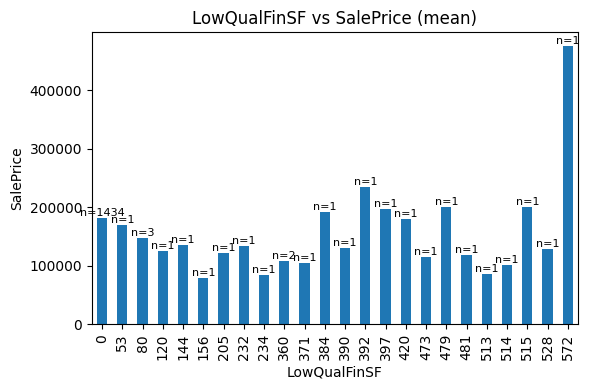

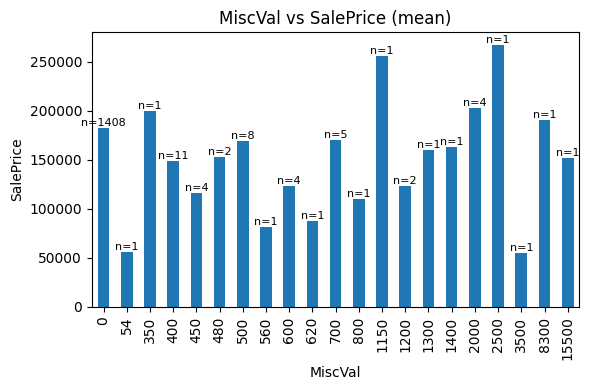

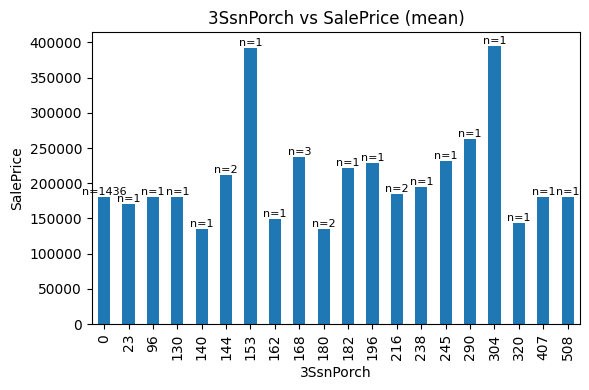

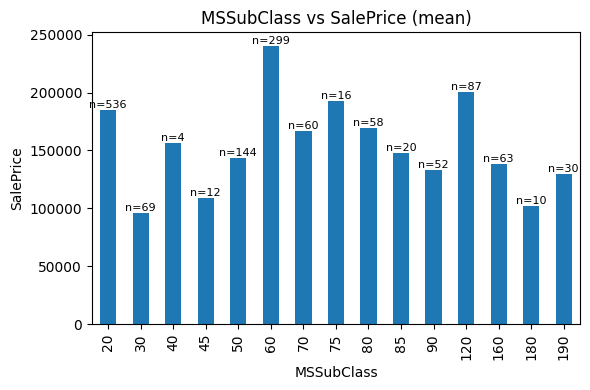

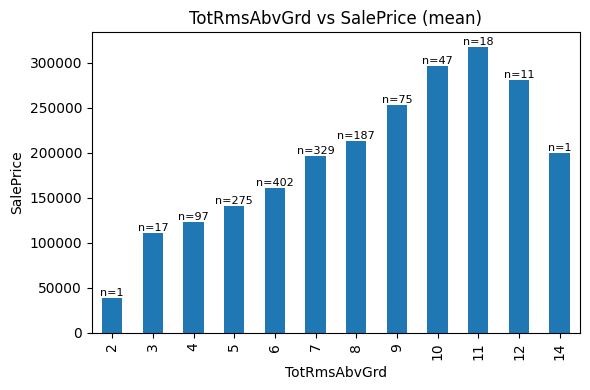

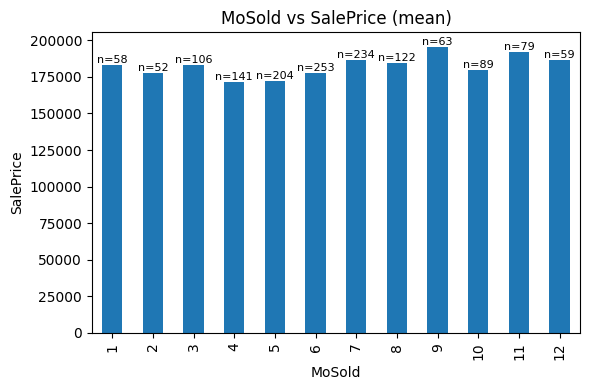

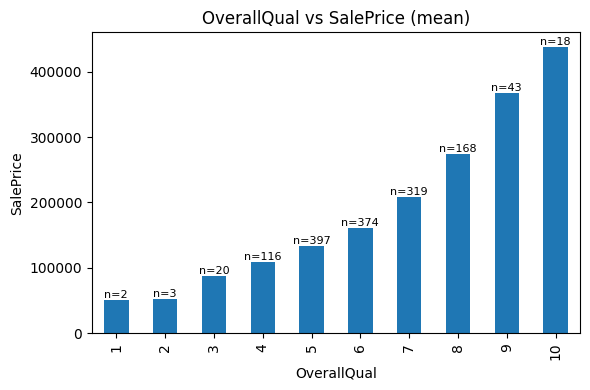

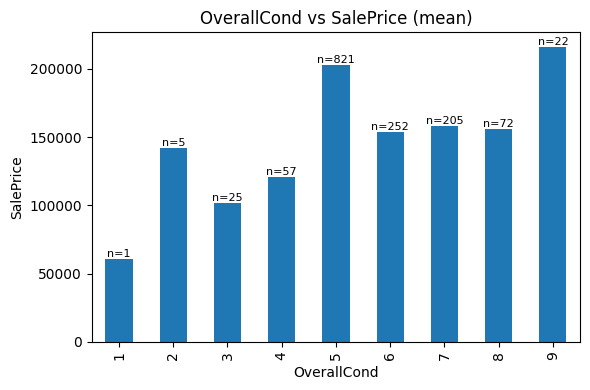

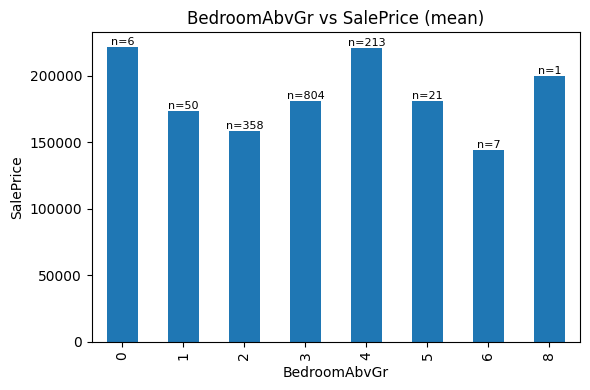

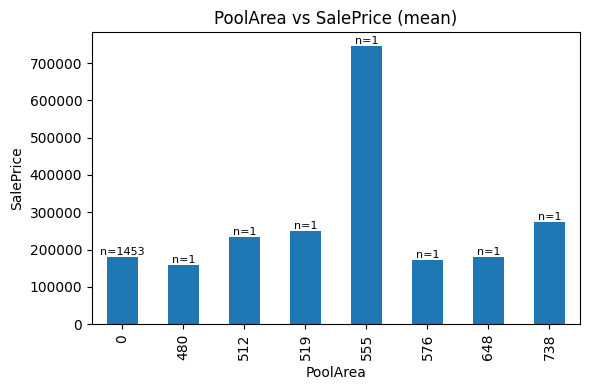

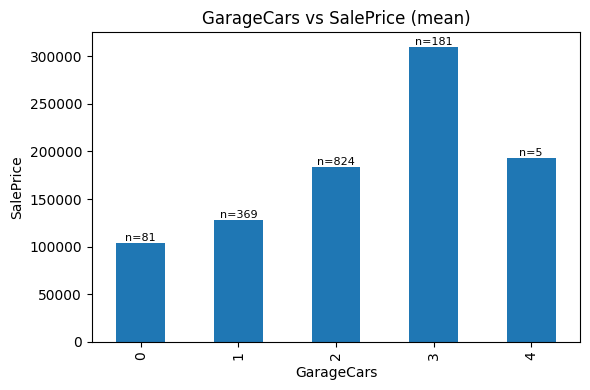

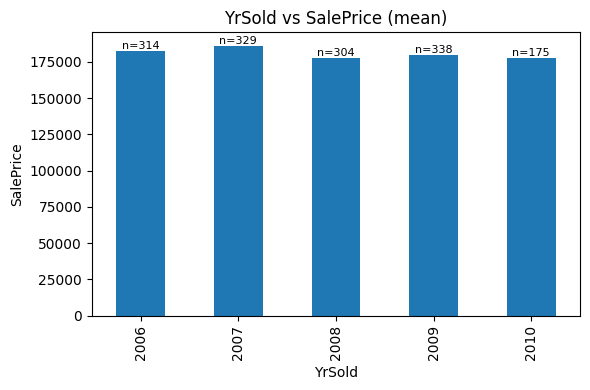

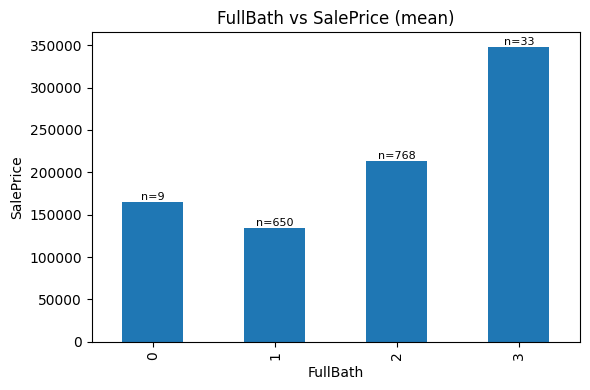

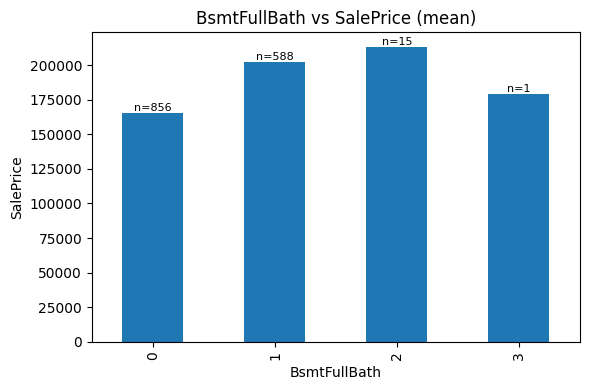

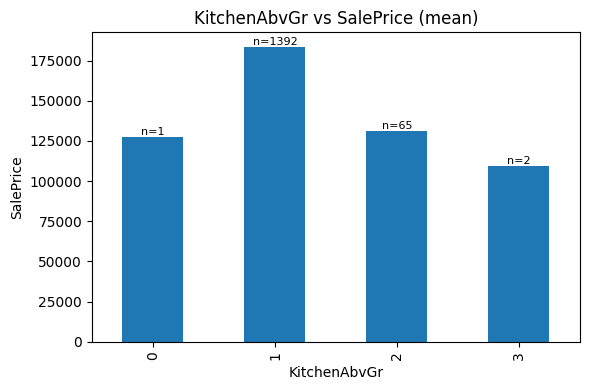

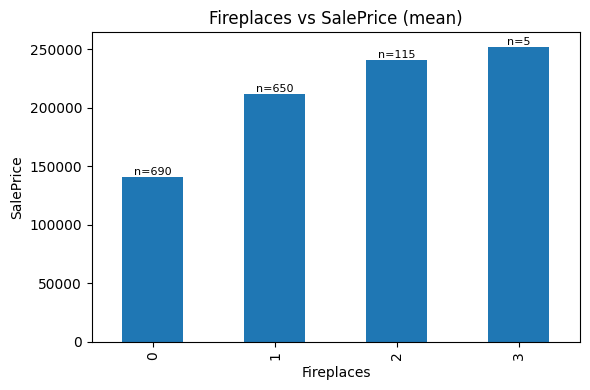

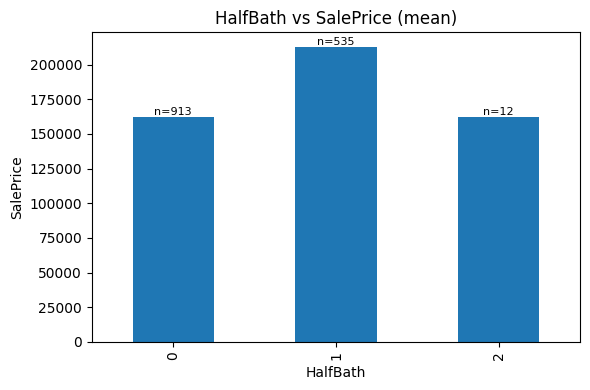

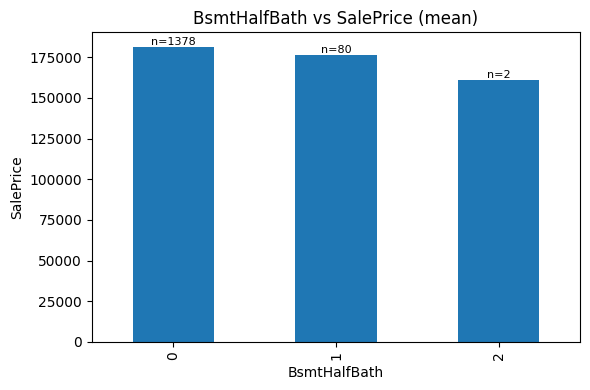

In [66]:
for col in low_card_num_cols:
    plot_target_by_category(train_eda, col)
    plt.show()

In [102]:
collapse_to_binary_cols = ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']
nominal_cols = ['MSSubClass', 'MoSold']
imabalanced = {
    'KitchenAbvGr': 'collapse to multiple kitches flag.',
    'TotRmsAbvGrd': 'join 2 and 3, and 10, 11, 12, 14',
    'OverallCond': 'collapsed into poor average good',
    'BedroomAbvGr': 'Collapse to 3 bins (Small / Typical / Large) OR drop in favor of TotRmsAbvGrd.',
    'GarageCars': 'collapse 4 into 3'
}

In [73]:
#None of the low_card_num_cols have any null entries.
num_audit.loc[low_card_num_cols]

nunique  na_rate  zero_rate  dtype  corr_num
LowQualFinSF       24      0.0   0.982192  int64 -0.025606
MiscVal            21      0.0   0.964384  int64 -0.021190
3SsnPorch          20      0.0   0.983562  int64  0.044584
MSSubClass         15      0.0   0.000000  int64 -0.084284
TotRmsAbvGrd       12      0.0   0.000000  int64  0.533723
MoSold             12      0.0   0.000000  int64  0.046432
OverallQual        10      0.0   0.000000  int64  0.790982
OverallCond         9      0.0   0.000000  int64 -0.077856
BedroomAbvGr        8      0.0   0.004110  int64  0.168213
PoolArea            8      0.0   0.995205  int64  0.092404
GarageCars          5      0.0   0.055479  int64  0.640409
YrSold              5      0.0   0.000000  int64 -0.028923
FullBath            4      0.0   0.006164  int64  0.560664
BsmtFullBath        4      0.0   0.586301  int64  0.227122
KitchenAbvGr        4      0.0   0.000685  int64 -0.135907
Fireplaces          4      0.0   0.472603  int64  0.466929
HalfBath            3      0.0   0.625342  int64  0.284108
BsmtHalfBath        3      0.0   0.943836  int64 -0.016844

### High Cardinality Numerical Features

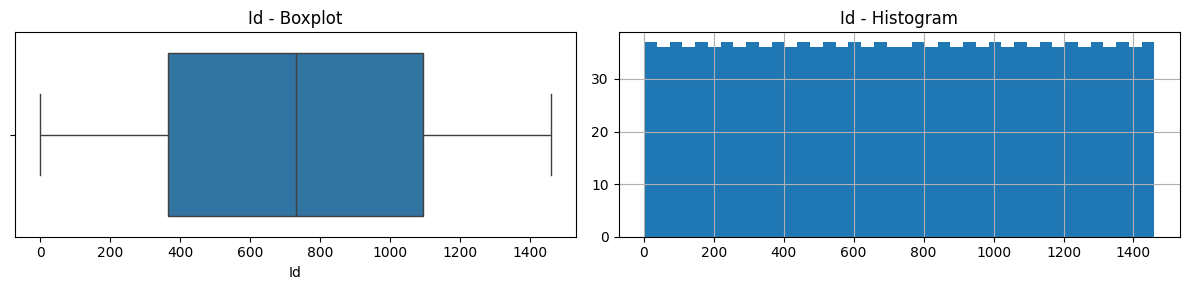

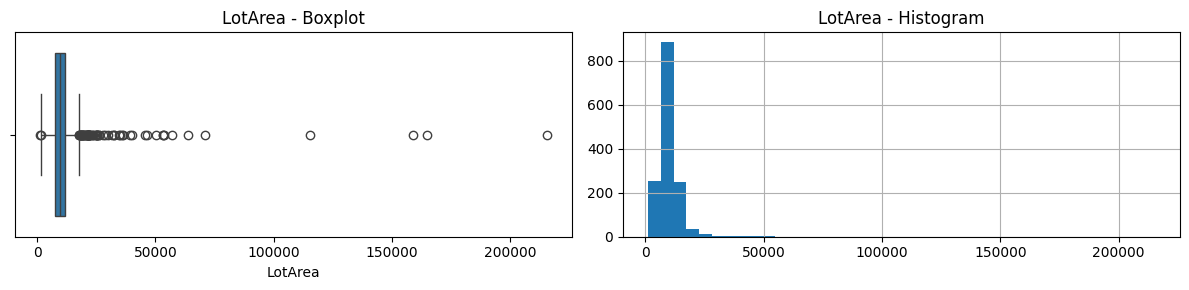

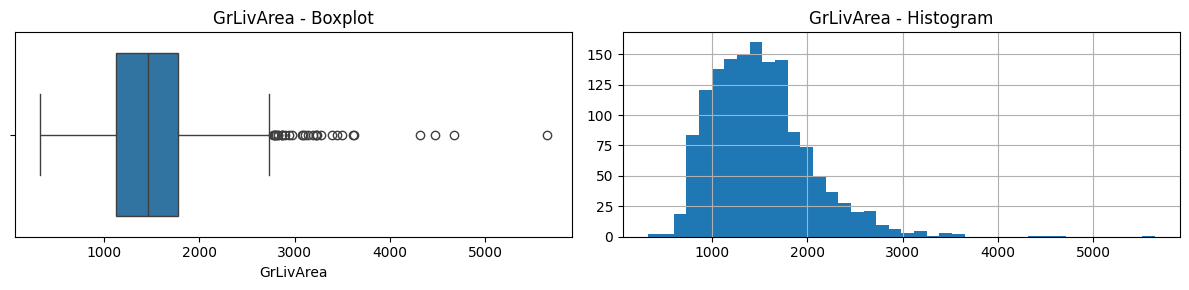

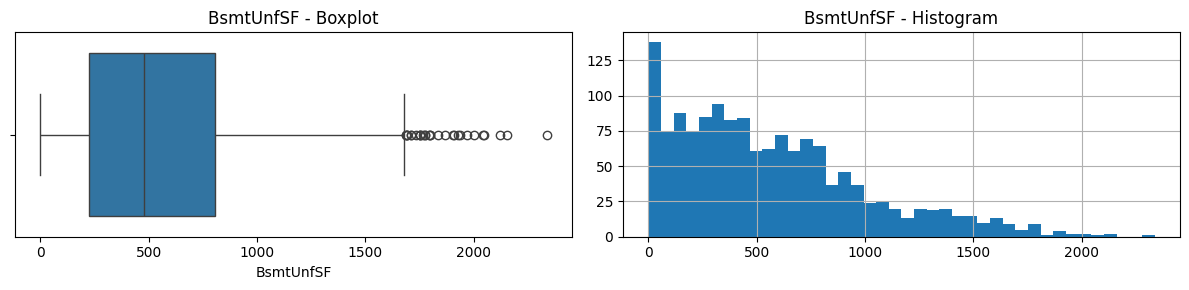

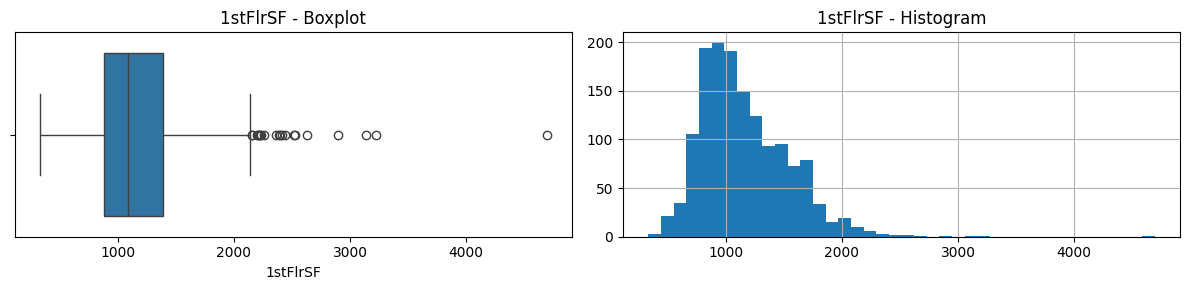

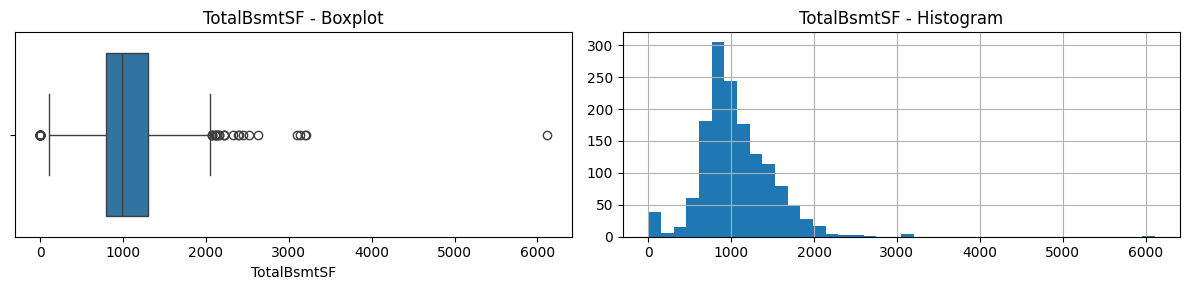

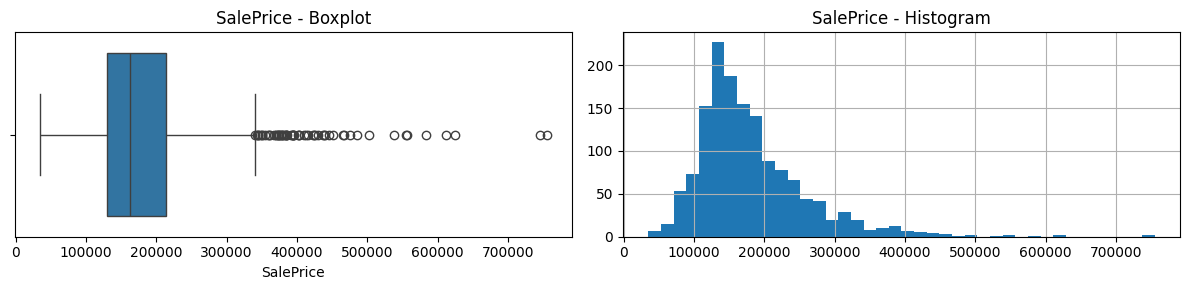

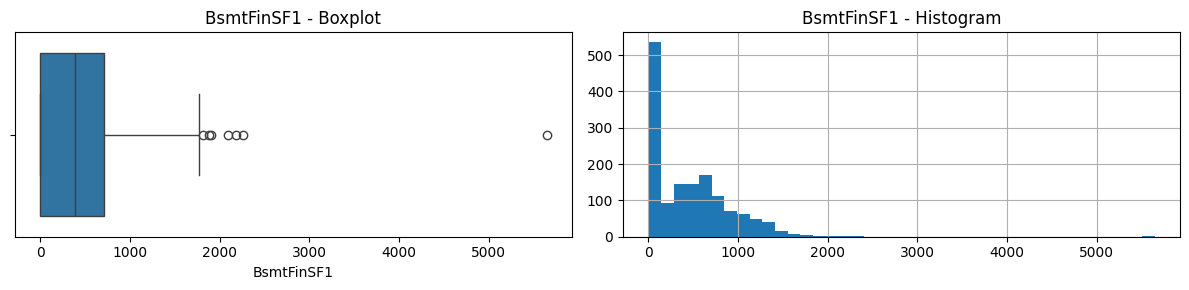

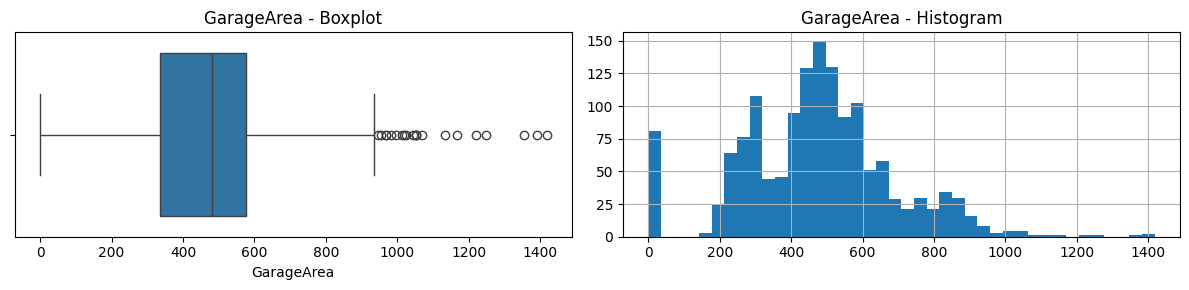

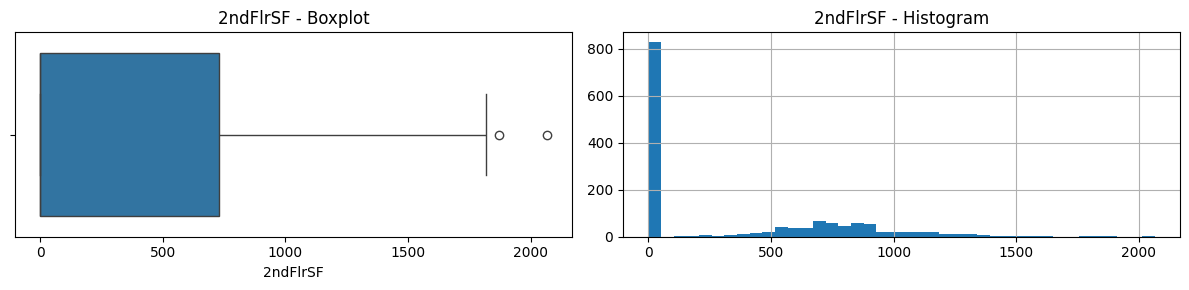

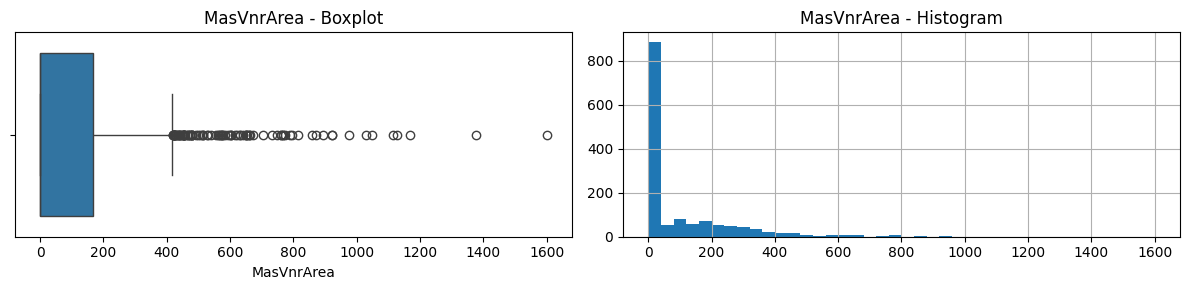

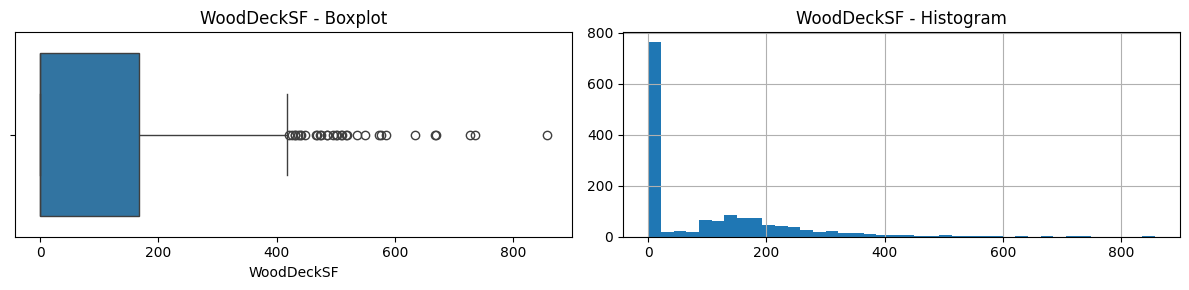

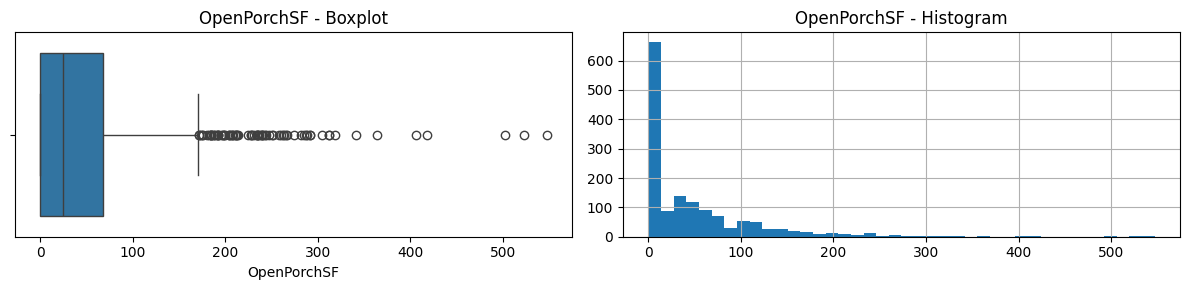

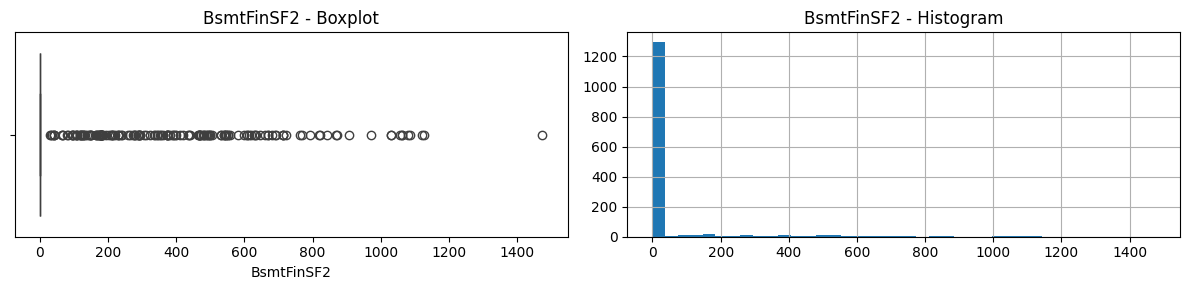

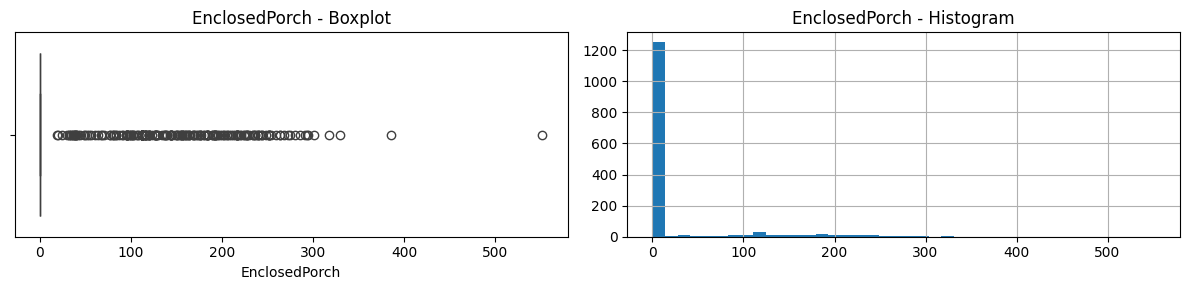

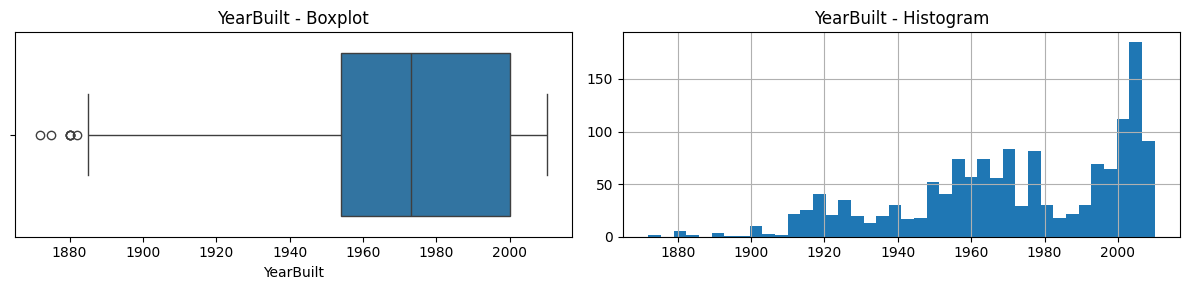

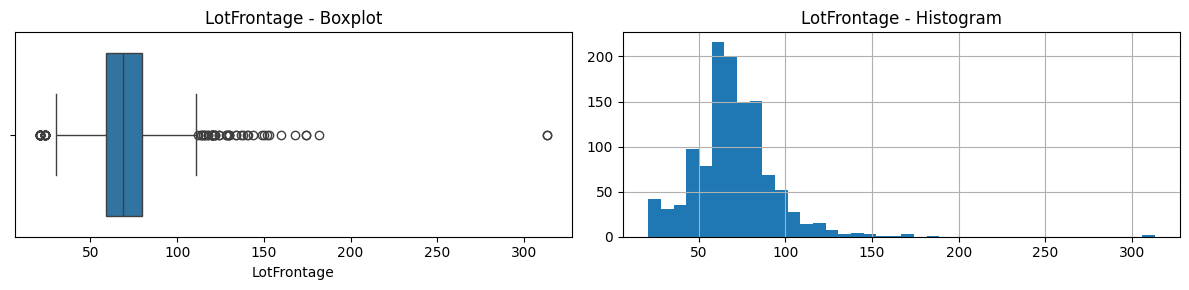

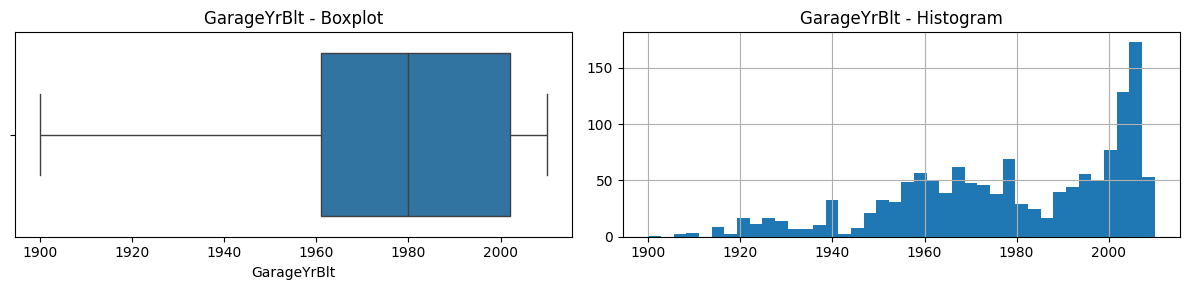

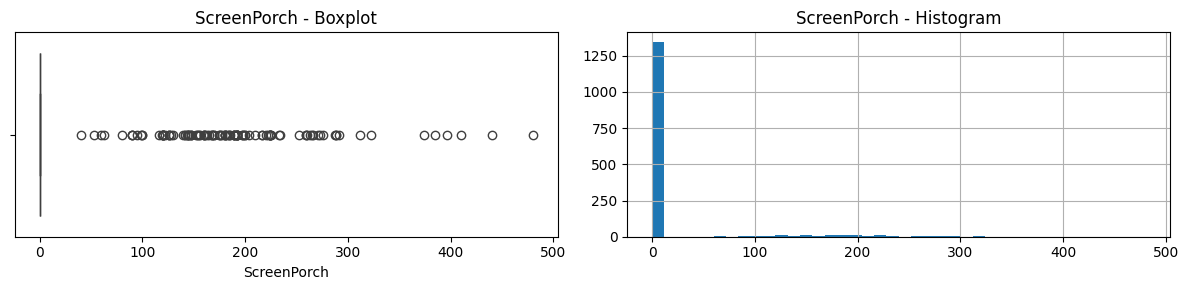

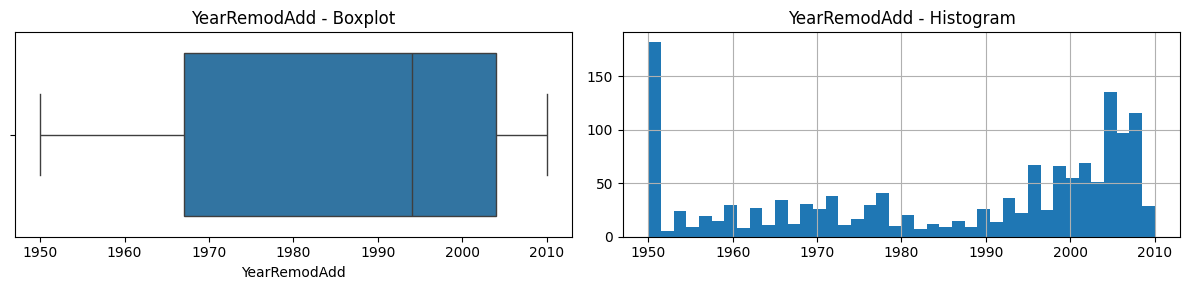

In [77]:
for col in high_card_num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    # Boxplot
    sns.boxplot(x=train_eda[col], ax=axes[0])
    axes[0].set_title(f"{col} - Boxplot")
    
    # Histogram
    train_eda[col].hist(bins=40, ax=axes[1])
    axes[1].set_title(f"{col} - Histogram")
    
    plt.tight_layout()
    plt.show()


In [103]:
# Continuous numeric features with strong right skew and outliers. Typically benefit from log/Box-Cox transforms.
right_skewed_cols = ['LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'SalePrice', 'smtFinSF1', 'GarageArea', '1stFlrSF', 'TotalBsmtSF']

#Sparse features with >90% zeros. Best simplified to binary flags (has/doesn't have) rather than kept as continuous.
collapse_to_binary_cols  += ['BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch']

# Zero-inflated but with meaningful nonzero spread. Should be treated as continuous (possibly log-transformed) plus an added binary flag.
skewed_and_binary = ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']

In [80]:
train_eda[high_card_num_cols].skew().sort_values(ascending=False)

LotArea          12.207688
BsmtFinSF2        4.255261
ScreenPorch       4.122214
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
GarageArea        0.179981
Id                0.000000
YearRemodAdd     -0.503562
YearBuilt        -0.613461
GarageYrBlt      -0.649415
dtype: float64

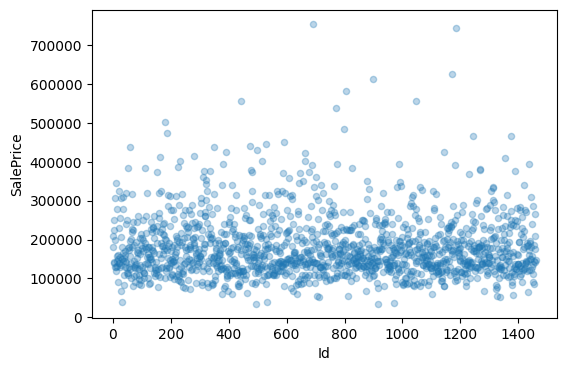

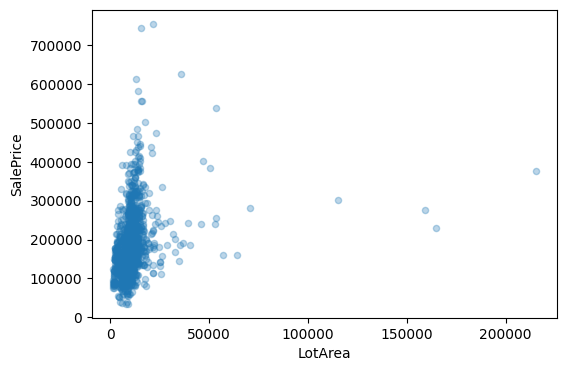

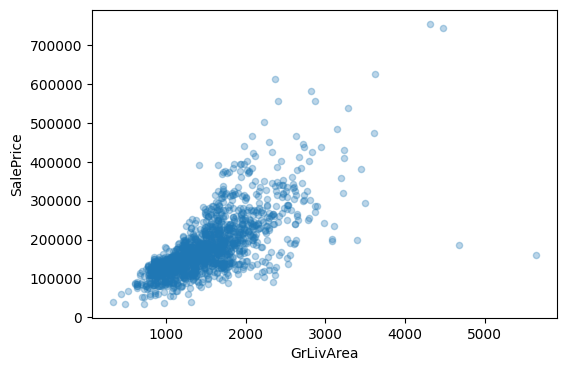

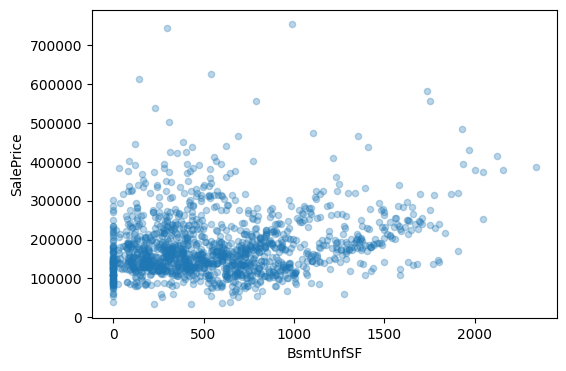

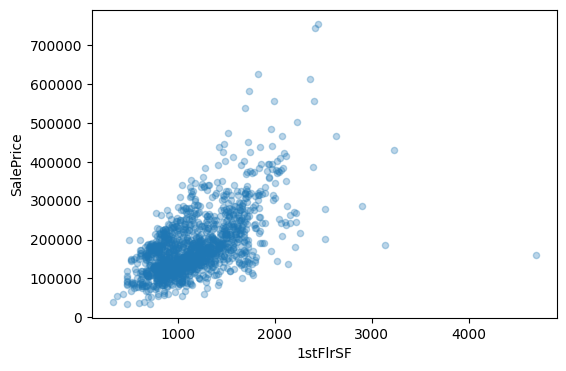

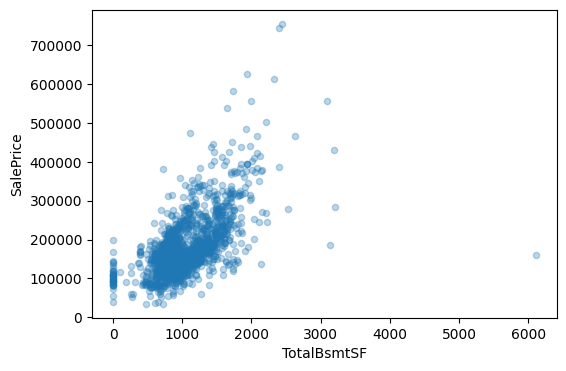

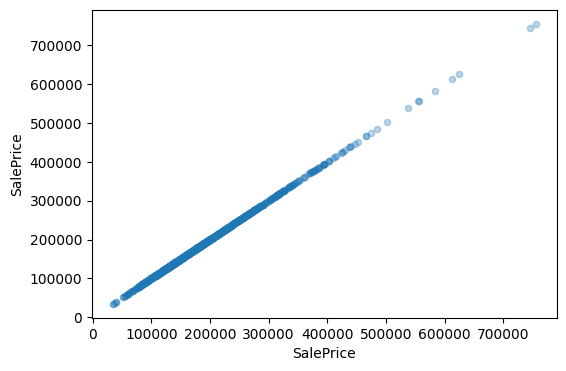

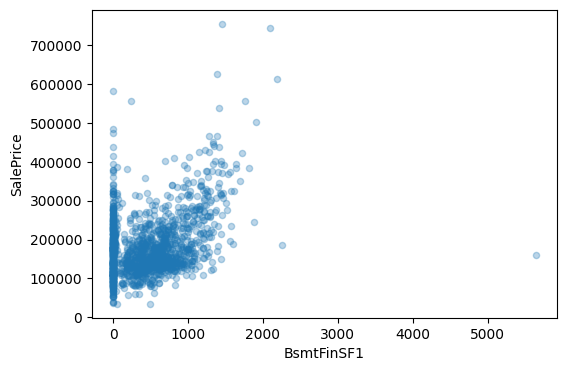

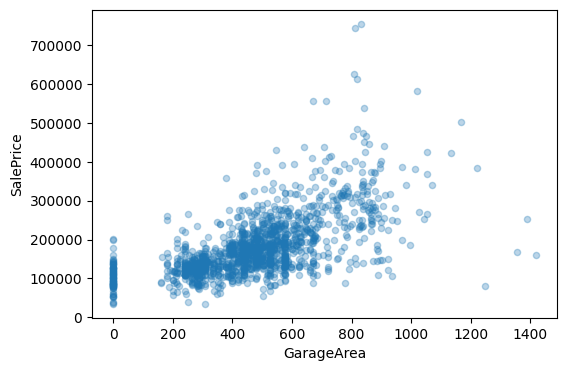

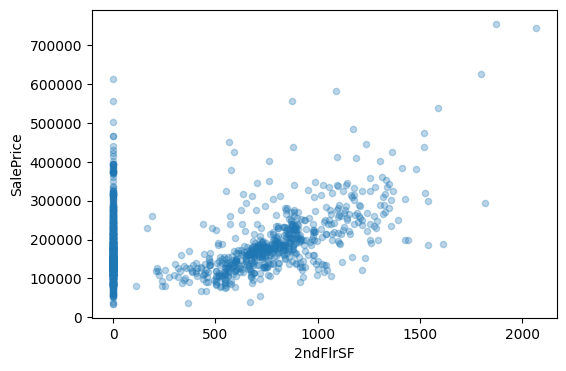

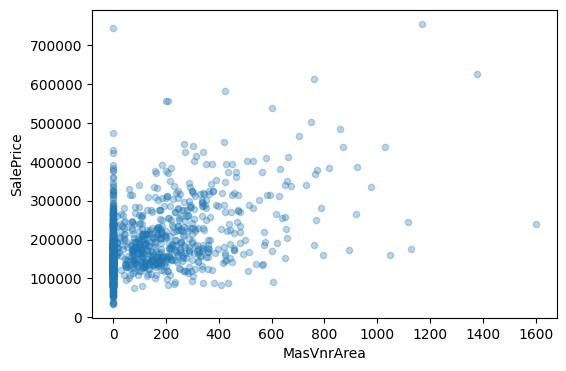

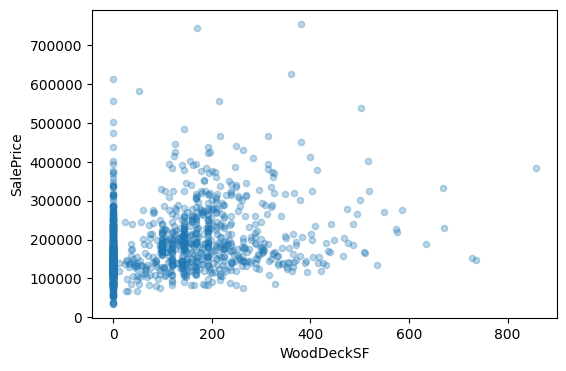

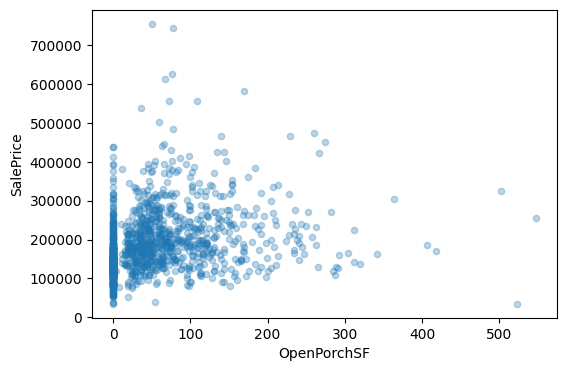

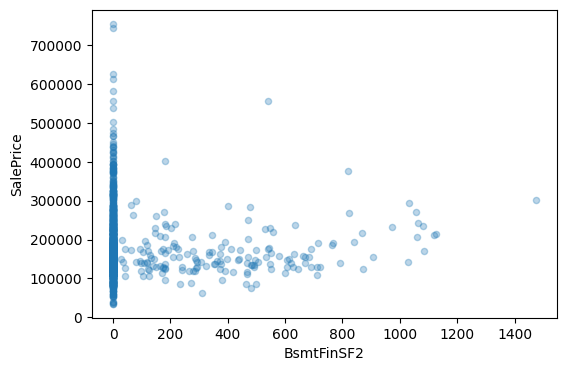

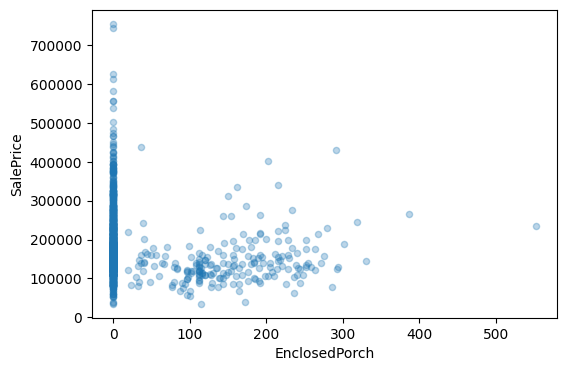

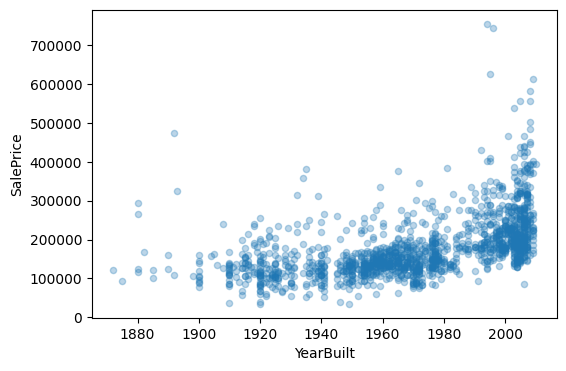

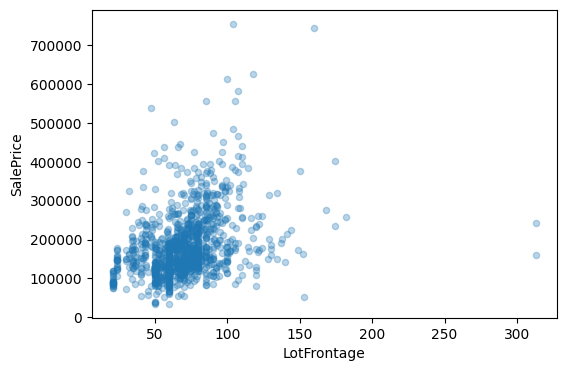

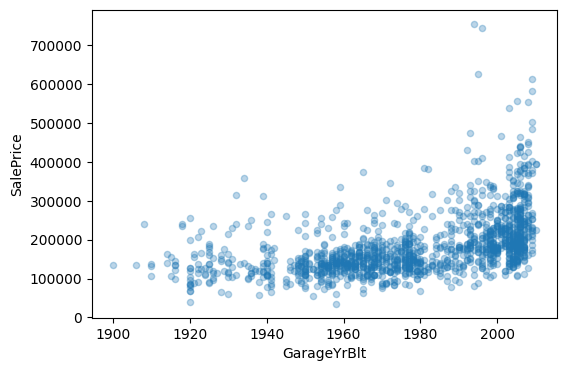

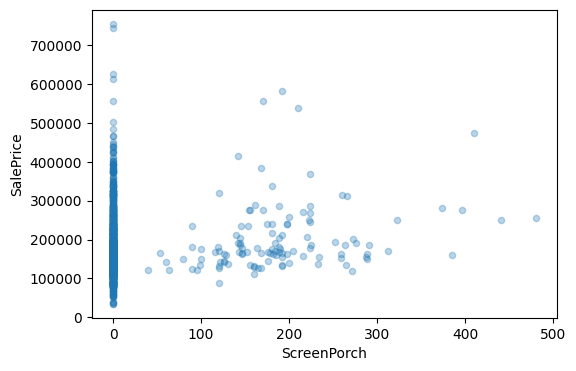

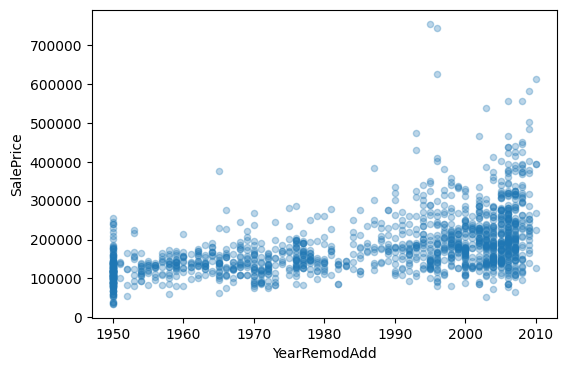

In [81]:
for col in high_card_num_cols:
    train_eda.plot.scatter(x=col, y="SalePrice", alpha=0.3, figsize=(6,4))

## Object Features

For features of object datatype, the main task is to classify them as ordinal or nominal. However, additional categorizations may also be applied as they become relevant for modeling.

In [83]:
obj_audit = quick_audit(train_eda.select_dtypes(include='object'))
obj_audit

nunique   na_rate  zero_rate   dtype
Neighborhood        25  0.000000        0.0  object
Exterior2nd         16  0.000000        0.0  object
Exterior1st         15  0.000000        0.0  object
Condition1           9  0.000000        0.0  object
SaleType             9  0.000000        0.0  object
HouseStyle           8  0.000000        0.0  object
RoofMatl             8  0.000000        0.0  object
Condition2           8  0.000000        0.0  object
Functional           7  0.000000        0.0  object
BsmtFinType2         6  0.026027        0.0  object
RoofStyle            6  0.000000        0.0  object
BsmtFinType1         6  0.025342        0.0  object
SaleCondition        6  0.000000        0.0  object
Heating              6  0.000000        0.0  object
Foundation           6  0.000000        0.0  object
GarageType           6  0.055479        0.0  object
ExterCond            5  0.000000        0.0  object
LotConfig            5  0.000000        0.0  object
MSZoning             5  0.000000        0.0  object
GarageCond           5  0.055479        0.0  object
GarageQual           5  0.055479        0.0  object
HeatingQC            5  0.000000        0.0  object
Electrical           5  0.000685        0.0  object
BldgType             5  0.000000        0.0  object
FireplaceQu          5  0.472603        0.0  object
LandContour          4  0.000000        0.0  object
LotShape             4  0.000000        0.0  object
KitchenQual          4  0.000000        0.0  object
MiscFeature          4  0.963014        0.0  object
Fence                4  0.807534        0.0  object
BsmtCond             4  0.025342        0.0  object
ExterQual            4  0.000000        0.0  object
BsmtExposure         4  0.026027        0.0  object
BsmtQual             4  0.025342        0.0  object
LandSlope            3  0.000000        0.0  object
PoolQC               3  0.995205        0.0  object
GarageFinish         3  0.055479        0.0  object
PavedDrive           3  0.000000        0.0  object
MasVnrType           3  0.597260        0.0  object
Utilities            2  0.000000        0.0  object
Alley                2  0.937671        0.0  object
Street               2  0.000000        0.0  object
CentralAir           2  0.000000        0.0  object

In [104]:
# Some features refer to quality, while some refer to type. The former is suggests a nominal data type, while the latter ordinal. lets inspect further
qual_cols = [c for c in train_eda.select_dtypes(include='object').columns if 
             any(x in c.lower() for x in ['condition', 'cond', 'qual', 'qc', 'qu', ])]
type_cols = [c for c in train_eda.select_dtypes(include='object').columns if 'type' in c.lower()]

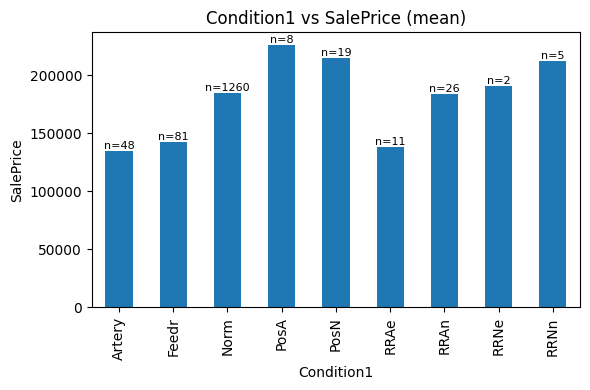

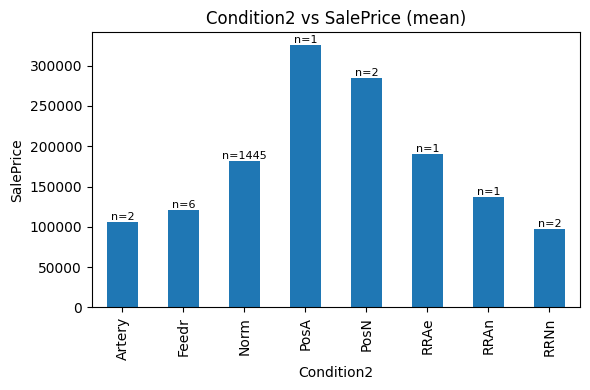

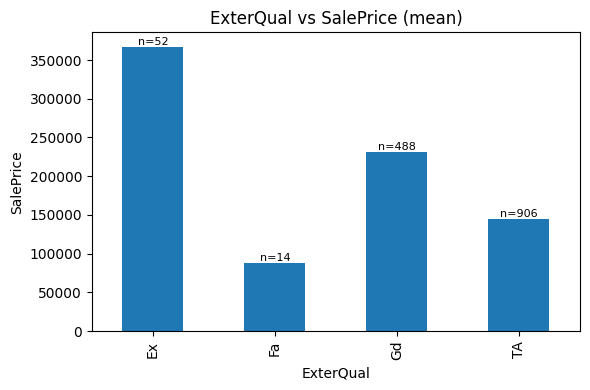

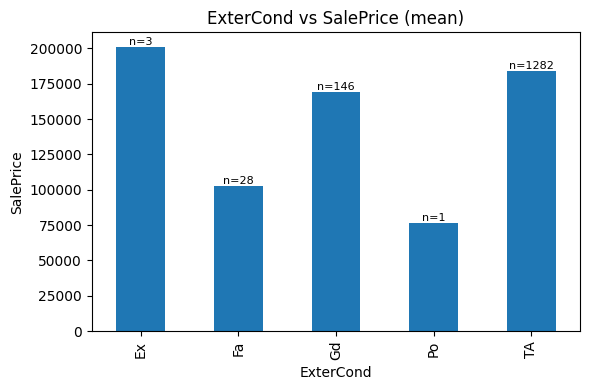

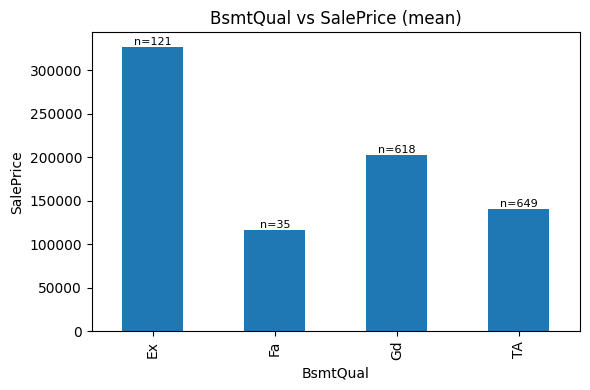

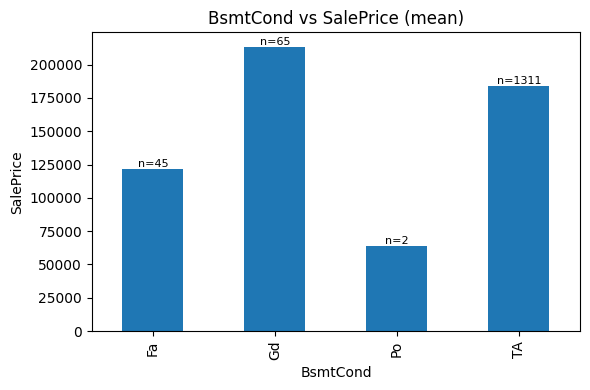

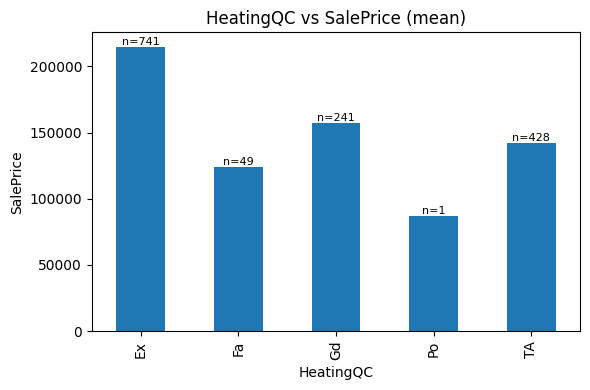

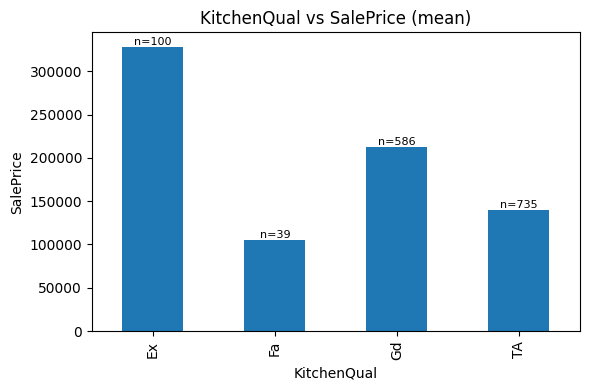

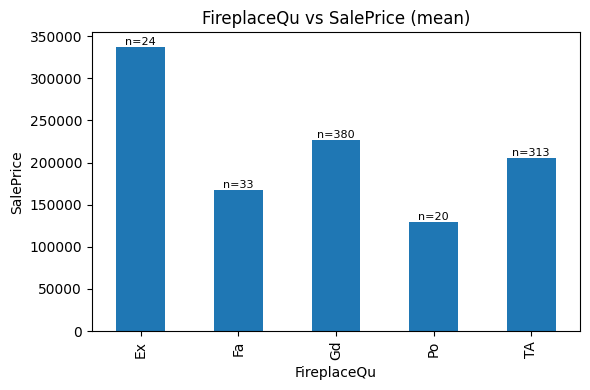

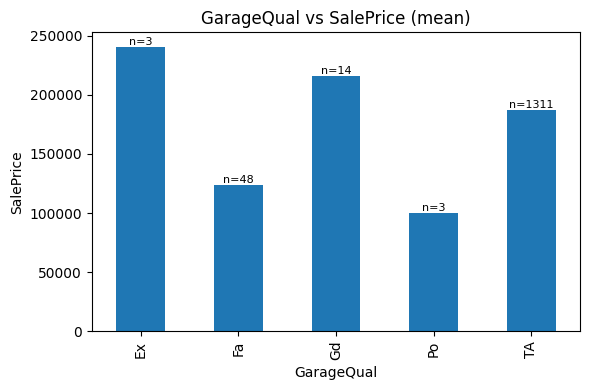

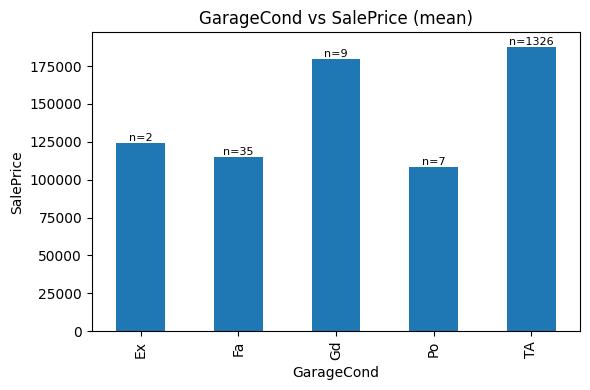

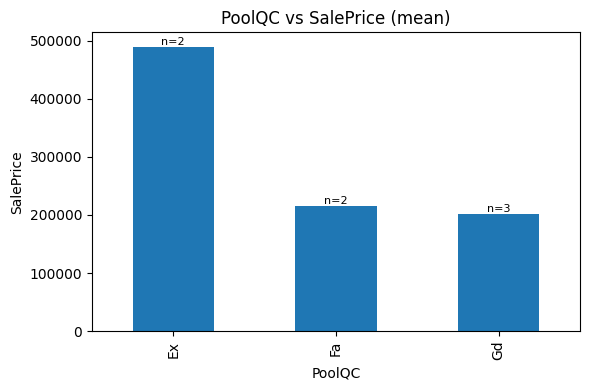

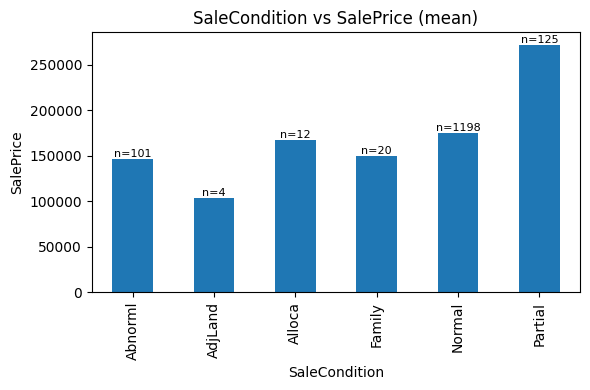

In [87]:
#To verify, lets prlot each category against the target. This will give us more information about the distribution and the behavior.
for col in qual_cols:
    plot_target_by_category(train_eda, col)

In [105]:
#It seems that the three columns with 'Condition' in their name are nominal, but the rest are ordinal
qual_cols = [x for x in qual_cols if 'condition' not in x.lower()]
qual_map = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1
}

In [106]:
#other insights
imbalanced_object = {
    'Condition1': 'Collapse very rare categories (<= 5 obs) into "other"',
    'Condition2': 'Collapse into "Norm" vs "Other"',
    'SaleCondition': 'collapse Adjland, alloca, and family into other',
    'GarageType': 'collapse less than 10 into other',
    'SaleType': 'Collapse less than 10 into other',
    'Exterior2nd':'combine less than and combine Wd Sdng and Wd Shng',
    'Exterior1st': 'combine less than and combine Wd Sdng and Wd Shng',
    'RoofMatl': 'collapse into other all except CompShg and WdShngl',
    'RoofStyle': 'keep Gambrel and Hip, collapse others into other',
    'heating': 'keep GasA and GasW, collapse others into other',
    'Foundation': 'collapse stone and wood into others',
    'Electrical': 'collapse FusP and Mix',
}

drop = ['PoolQC', 'MiscFeature', 'Utilities']

collapse_to_binary_cols += ['Fence', 'Alley']

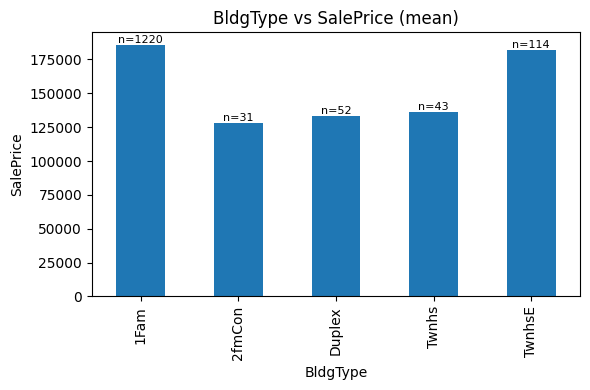

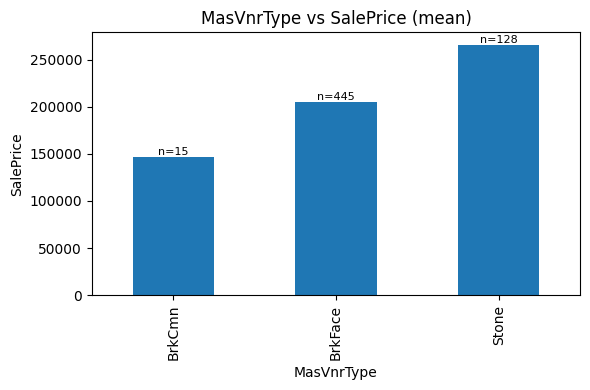

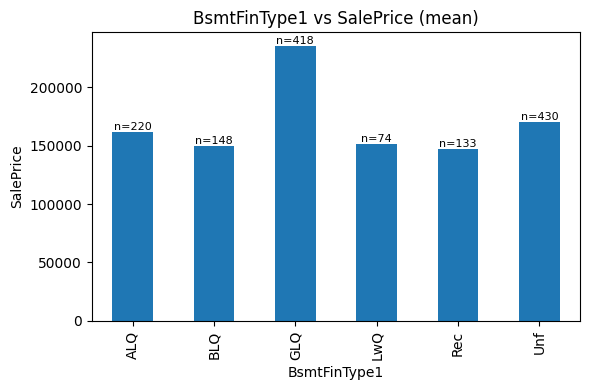

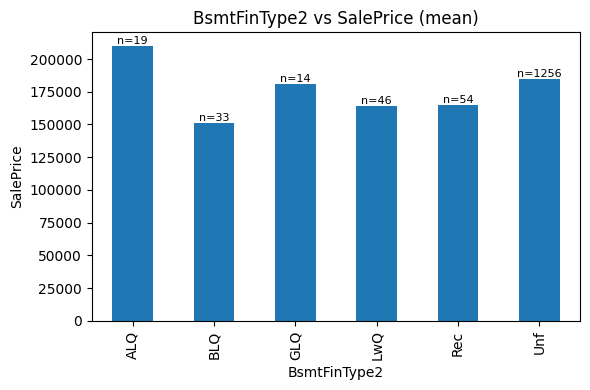

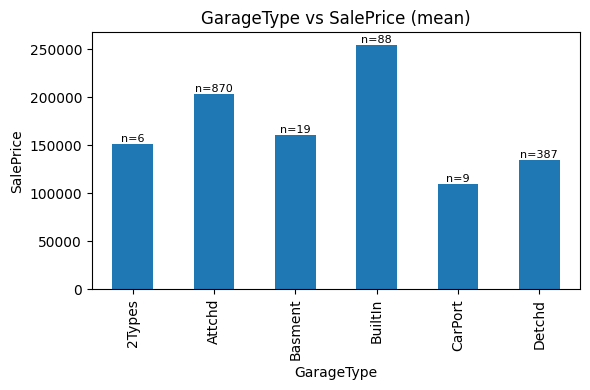

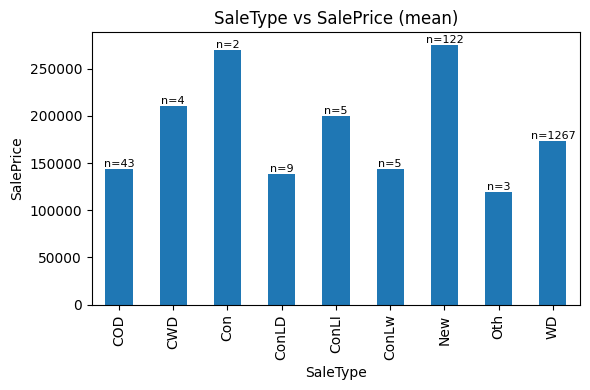

In [92]:
#now lets inspect the type features
for col in type_cols:
    plot_target_by_category(train_eda, col)

In [107]:
#The two bsmt features above are ordinal
nominal_cols += [c for c in type_cols if 'bsmt' not in c.lower()] + ['Condition1', 'Condition2', 'SaleCondition'] 

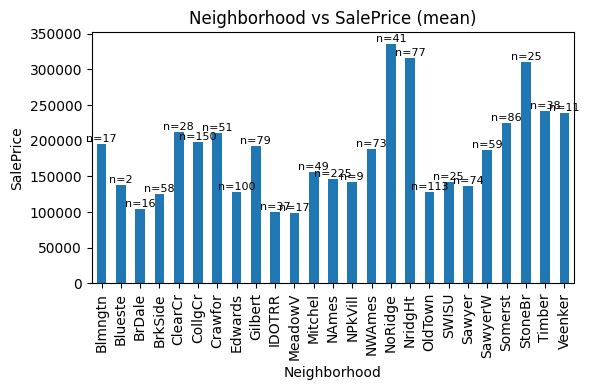

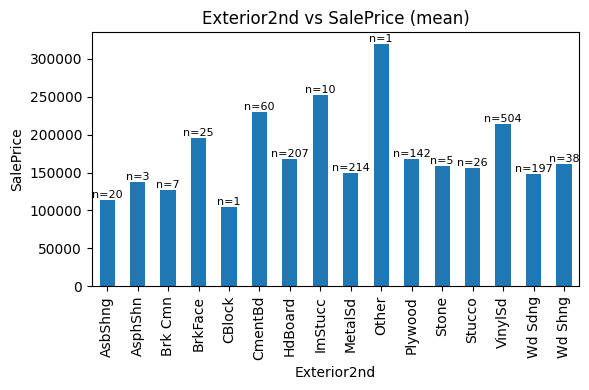

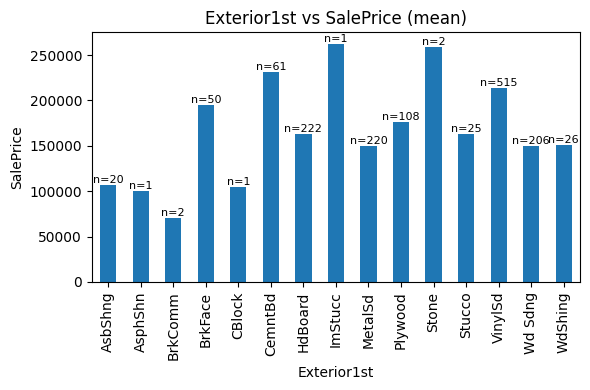

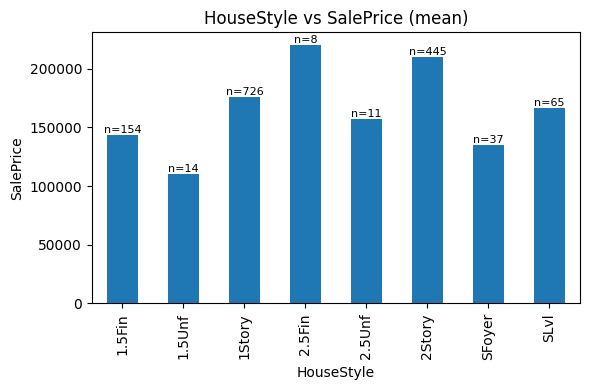

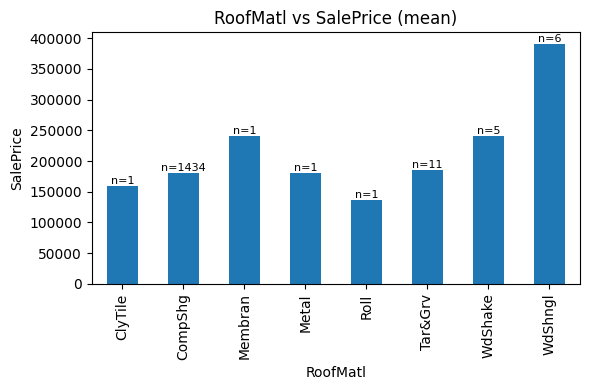

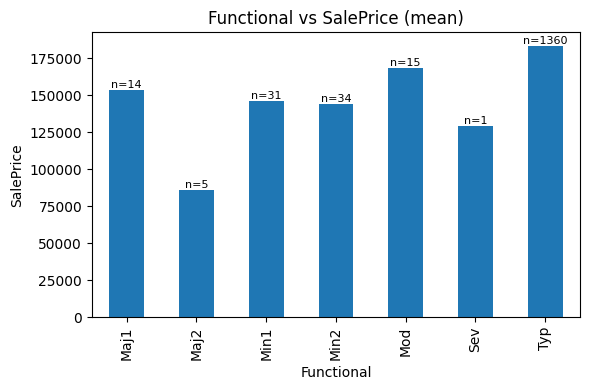

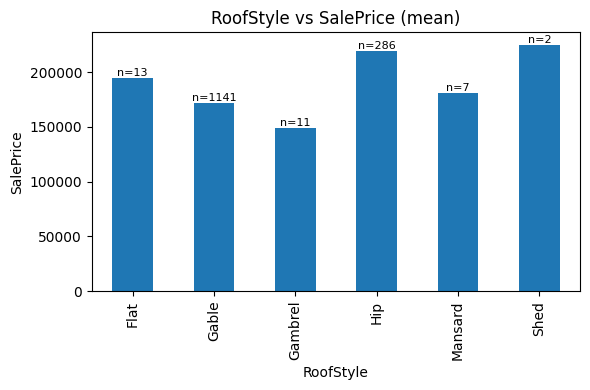

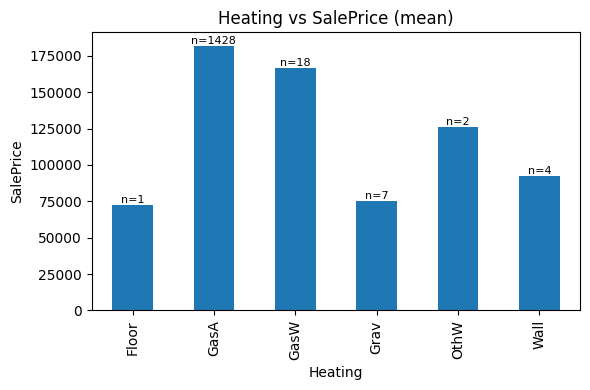

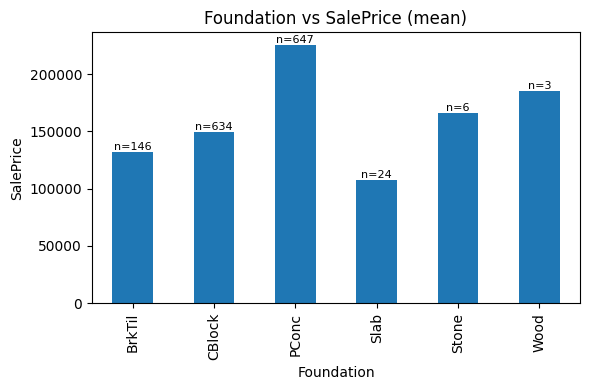

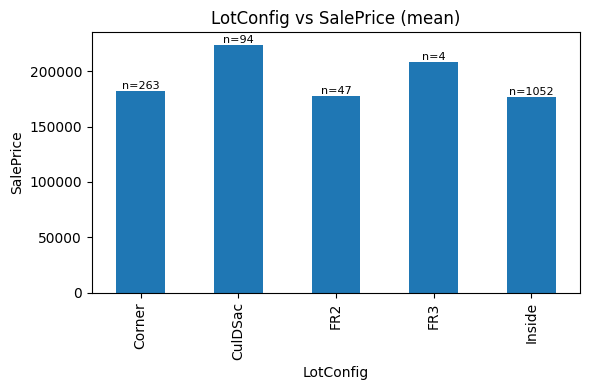

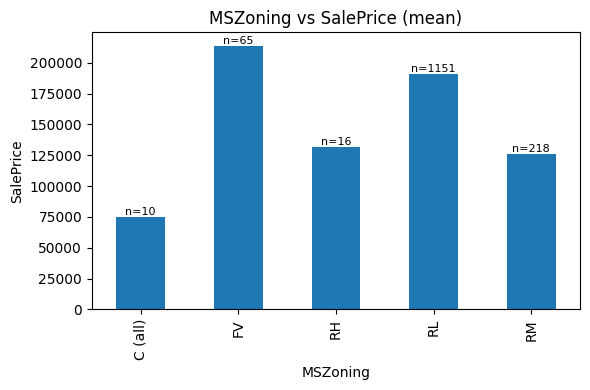

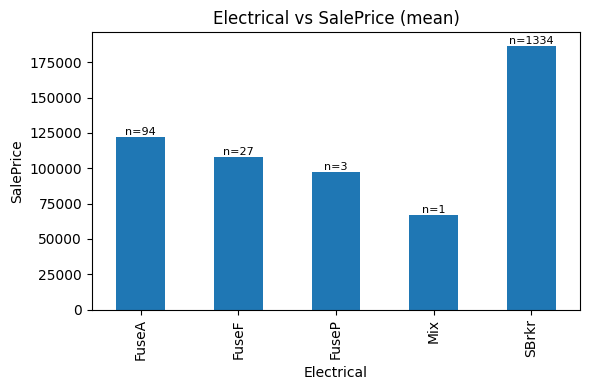

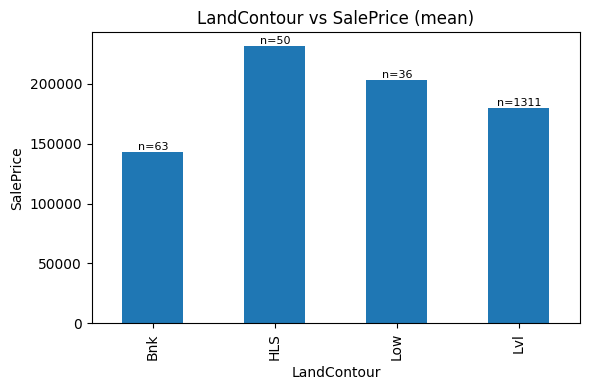

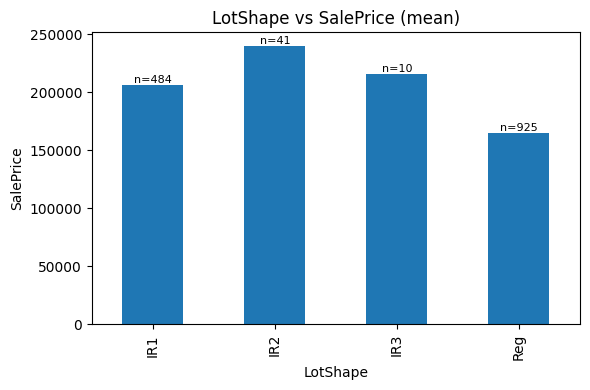

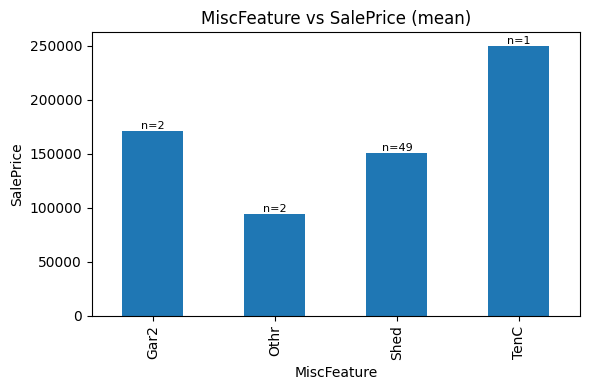

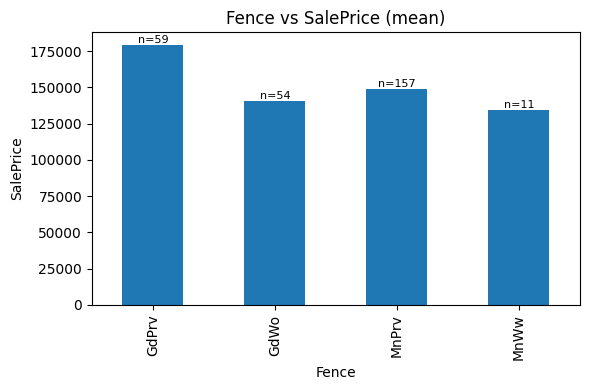

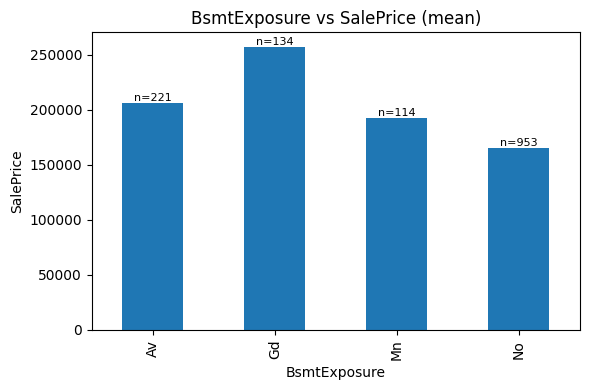

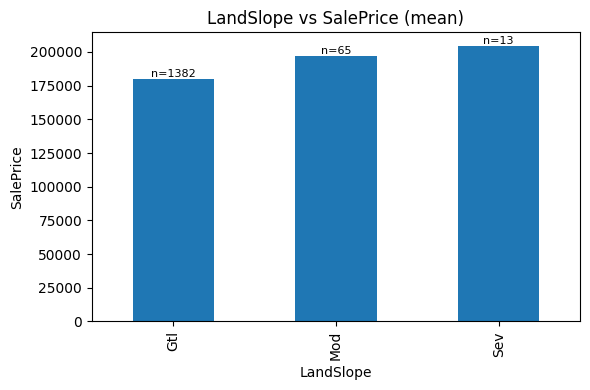

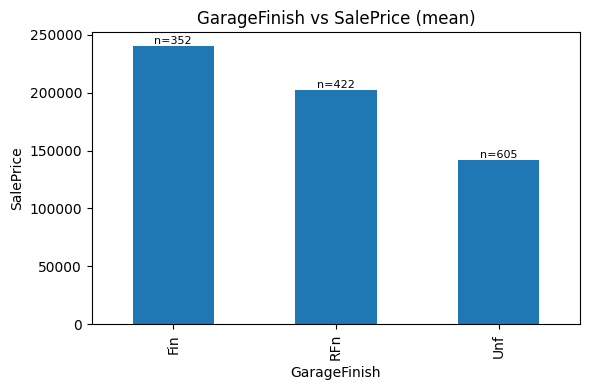

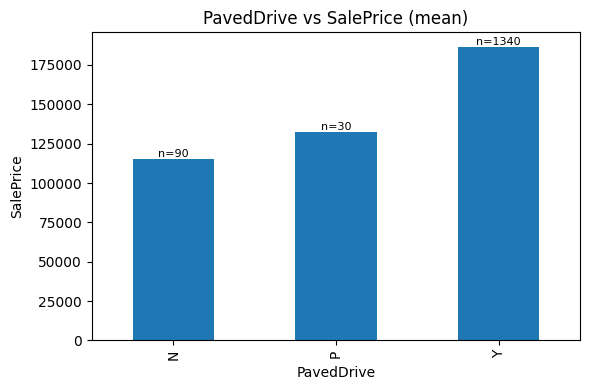

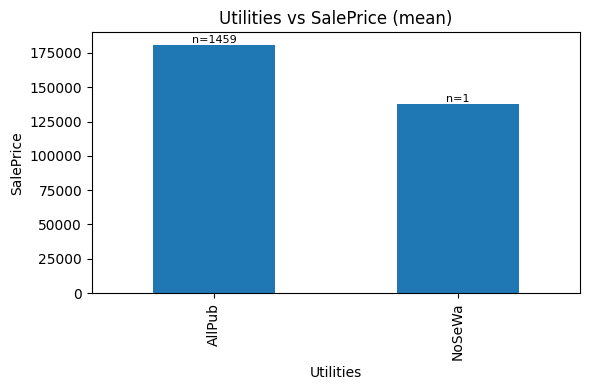

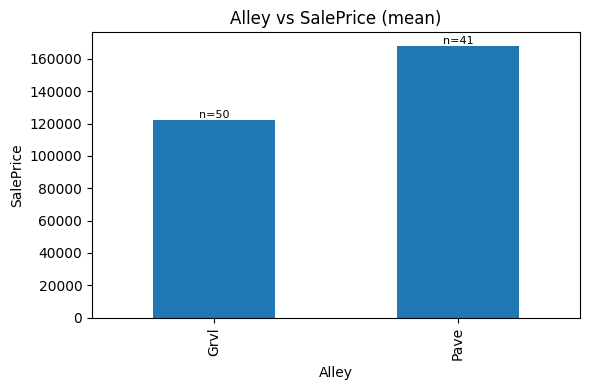

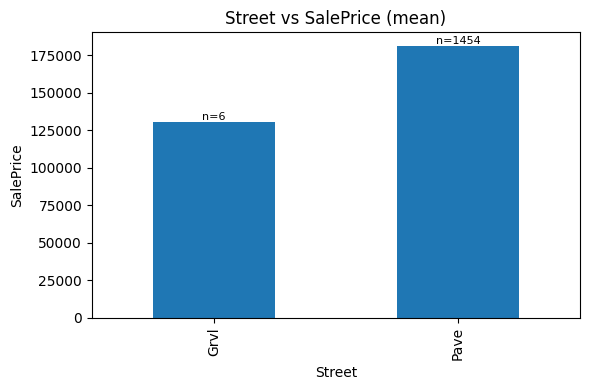

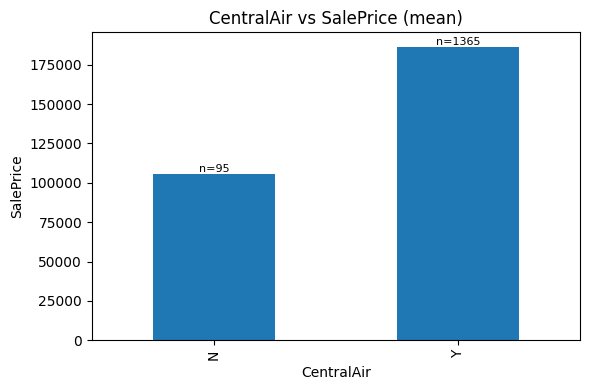

In [95]:
#now the rest of object features
for col in [c for c in obj_audit.index if c not in nominal_cols + qual_cols]:
    plot_target_by_category(train_eda, col)

In [108]:
obj_ordinal_cols = qual_cols + ['Functional', 'LandContour', 'LotShape', 'BsmtExposure', 'LandSlope',
                                'GarageFinish', 'PavedDrive']
obj_already_binary_cols = ['Street', 'CentralAir']
functional_map = {
    'Typ': 0,
    'Mod': 1,
    'Min1': 2,
    'Min2': 3,
    'Maj1': 4,
    'Maj2': 5,
    'Sev': 5
}
LandContour_map = {
    "Low": 0,
    "HLS": 1,
    "Bnk": 2,
    "Lvl": 3
}
LotShape_map = {
    "IR3": 0,
    "IR2": 1,
    "IR1": 2,
    "Reg": 3
}
bsmtExposure_map = {
    'No': 0,
    'Mn': 1,
    'Av': 2,
    'Gd': 3
}
landSlope_map = {
    'Gtl': 0,
    'Mod': 1,
    'Sev': 2
}
GarageFinish_map = {
    'Unf': 0,
    'RFn': 1,
    'Fin': 2
}
PavedDrive_map = {
    'N': 0,
    'P': 1,
    'Y': 2
}

In [110]:
nominal_cols += [c for c in obj_audit.index if c not in nominal_cols + obj_ordinal_cols +
                obj_already_binary_cols + drop + collapse_to_binary_cols]

In [118]:
all_classified_cols = nominal_cols + collapse_to_binary_cols + right_skewed_cols + skewed_and_binary + drop + obj_ordinal_cols + obj_already_binary_cols
len(all_classified_cols)

70

In [120]:
remaining = [c for c in train_eda.columns.tolist() if c not in all_classified_cols]
remaining

['Id',
 'LotFrontage',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'YrSold']

<Axes: >

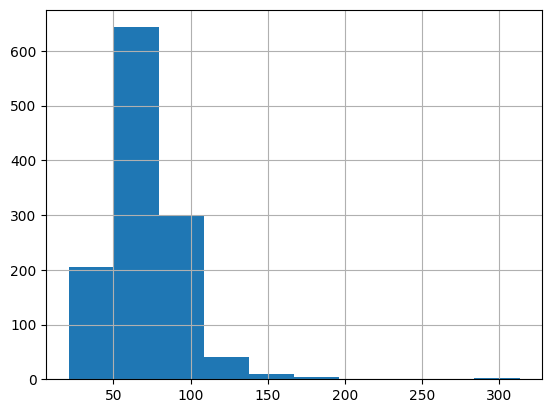

In [121]:
train_eda['LotFrontage'].hist()

In [122]:
drop.append('Id')
right_skewed_cols.append('LotFrontage')
year_cols = [c for c in train_eda.columns.tolist() if any(x in c.lower() for x in ['year', 'yr'])]

In [123]:
all_classified_cols = nominal_cols + collapse_to_binary_cols + right_skewed_cols + skewed_and_binary + drop + obj_ordinal_cols + obj_already_binary_cols + year_cols
remaining = [c for c in train_eda.columns.tolist() if c not in all_classified_cols]
len(all_classified_cols), len(remaining)

(76, 9)

In [129]:
num_ordinal_cols = remaining
all_classified_cols += num_ordinal_cols
len(all_classified_cols)

94

In [131]:
remaining = [c for c in train_eda.columns.tolist() if c not in all_classified_cols]
remaining

[]

In [152]:
from collections import Counter

counts = Counter(all_classified_cols)
overlap_counts = [(index, col, count) for index, (col, count) in enumerate(counts.items()) if (col, count)[1] > 1]
overlap_counts

[(37, '1stFlrSF', 2),
 (38, 'TotalBsmtSF', 2),
 (47, 'PoolQC', 2),
 (73, 'OverallQual', 2),
 (74, 'OverallCond', 2),
 (75, 'BsmtFinSF1', 2),
 (76, 'FullBath', 2),
 (77, 'BedroomAbvGr', 2),
 (78, 'KitchenAbvGr', 2),
 (79, 'TotRmsAbvGrd', 2),
 (80, 'Fireplaces', 2),
 (81, 'GarageCars', 2)]

In [141]:
len(counts), len(train_eda.columns)

(82, 81)

In [143]:
[col for (col, count) in counts.items() if col not in train_eda.columns.tolist()]

['smtFinSF1']

In [147]:
[index for index, (col, count) in enumerate(counts.items()) if (col, count)[0] == 'smtFinSF1']

[40]

In [149]:
len(nominal_cols), len(collapse_to_binary_cols)

(22, 12)

In [151]:
right_skewed_cols
right_skewed_cols.remove('smtFinSF1')

# Consolidating the final classification

In [159]:
all_classified_cols = nominal_cols + collapse_to_binary_cols + right_skewed_cols + skewed_and_binary + drop + obj_ordinal_cols + obj_already_binary_cols + year_cols + num_ordinal_cols
len(all_classified_cols)

84

In [161]:
counts2 = Counter(all_classified_cols)
[c for c, count, in counts2.items() if count > 1]

['1stFlrSF', 'TotalBsmtSF', 'PoolQC']

In [167]:
lists_dict = {
    "nominal_cols": nominal_cols,
    "collapse_to_binary_cols": collapse_to_binary_cols,
    "right_skewed_cols": right_skewed_cols,
    "skewed_and_binary": skewed_and_binary,
    "drop": drop,
    "obj_ordinal_cols": obj_ordinal_cols,
    "obj_already_binary_cols": obj_already_binary_cols,
    "year_cols": year_cols
}

In [166]:
[key for key, lst in lists_dict.items() if '1stFlrSF' in lst]

[]

In [170]:
right_skewed_cols
right_skewed_cols.remove('1stFlrSF')

In [171]:
[key for key, lst in lists_dict.items() if 'TotalBsmtSF' in lst]

['right_skewed_cols']

In [173]:
right_skewed_cols.remove( 'TotalBsmtSF')


In [174]:
[key for key, lst in lists_dict.items() if 'PoolQC' in lst]

['drop', 'obj_ordinal_cols']

In [175]:
obj_ordinal_cols.remove('PoolQC')

In [176]:
lists_dict = {
    "nominal_cols": nominal_cols,
    "collapse_to_binary_cols": collapse_to_binary_cols,
    "right_skewed_cols": right_skewed_cols,
    "skewed_and_binary": skewed_and_binary,
    "drop": drop,
    "obj_ordinal_cols": obj_ordinal_cols,
    "obj_already_binary_cols": obj_already_binary_cols,
    "year_cols": year_cols
}

In [177]:
all_classified_cols = nominal_cols + collapse_to_binary_cols + right_skewed_cols + skewed_and_binary + drop + obj_ordinal_cols + obj_already_binary_cols + year_cols + num_ordinal_cols
len(all_classified_cols)

81

In [178]:
[c for c in all_classified_cols if c not in train_eda.columns.tolist()]

[]

# Missing Values Analysis

When sorting features into buckets I also kept an eye on missingness, especially for columns with many blanks like PoolQC, Fence, Alley, or MiscFeature. In those cases the absence itself usually means something (no pool, no fence, etc.) or the feature is too sparse to be useful. But I can’t just rely on what’s missing in the training set, since any column might have gaps in the test set. To keep things consistent, I’ll deal with missing values according to the type of feature: medians for continuous numbers, most frequent values for ordinals, an added "Missing" category for nominals, zeros for binary flags, medians or related columns for years, and explicit "None" labels for sparse categoricals where absence has meaning. This way the pipeline will be ready for both the training and test data.

# Redundancy/Multicollinearity

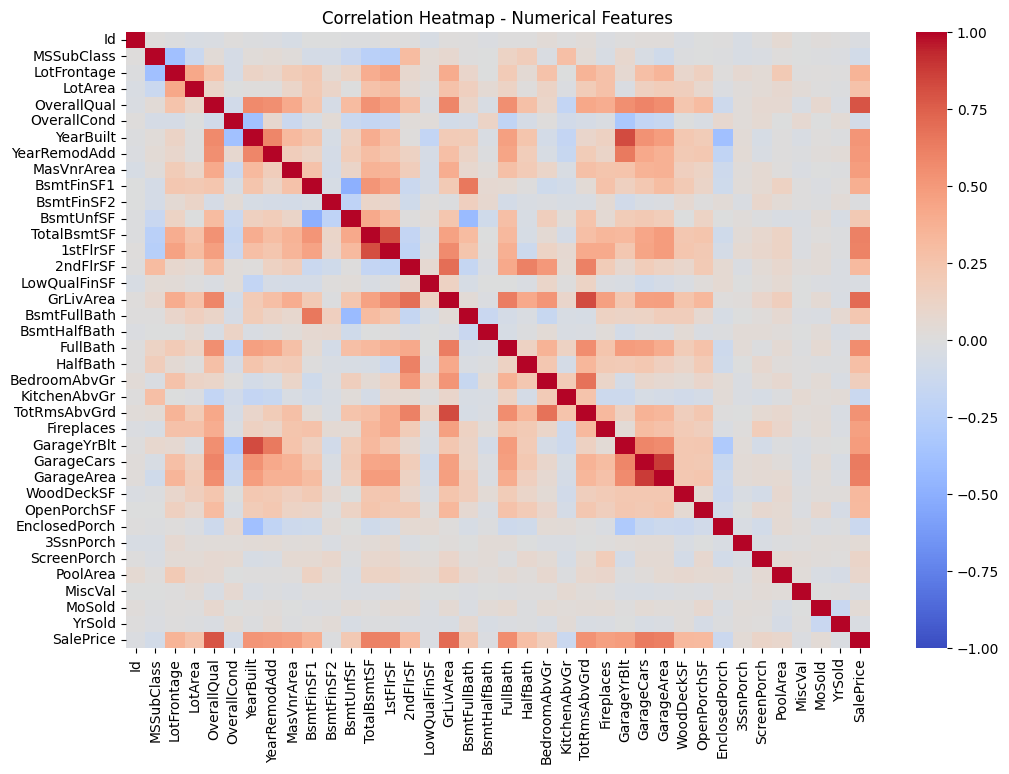

In [183]:
corr = train_eda.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap - Numerical Features")
plt.show()

In [185]:
# Find pairs of features with correlation above a threshold
threshold = 0.75
high_corr_pairs = (
    corr.where(lambda x: abs(x) > threshold)  # filter by threshold
        .stack()                              # flatten to Series
        .reset_index()
)
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['level_0'] != high_corr_pairs['level_1'])  # exclude self
]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

print(high_corr_pairs.sort_values(by="Correlation", ascending=False))


        Feature1      Feature2  Correlation
34    GarageCars    GarageArea     0.882475
35    GarageArea    GarageCars     0.882475
31   GarageYrBlt     YearBuilt     0.825667
8      YearBuilt   GarageYrBlt     0.825667
21     GrLivArea  TotRmsAbvGrd     0.825489
28  TotRmsAbvGrd     GrLivArea     0.825489
15   TotalBsmtSF      1stFlrSF     0.819530
16      1stFlrSF   TotalBsmtSF     0.819530
5    OverallQual     SalePrice     0.790982
46     SalePrice   OverallQual     0.790982


## redundant categorical columns

In [193]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    df = pd.DataFrame({"x": x, "y": y}).dropna()
    if df.empty:
        return np.nan

    confusion_matrix = pd.crosstab(df["x"], df["y"])
    if confusion_matrix.size == 0:
        return np.nan

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    if r == 1 or k == 1:
        return np.nan

    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)

    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return np.nan

    return np.sqrt(phi2corr / denom)

In [194]:
def check_categorical_redundancy(df, threshold=0.7):
    """
    Compute pairwise Cramér's V for categorical features.
    Returns a DataFrame of pairs above the threshold.
    """
    cat_cols = df.select_dtypes(include="object").columns
    results = []

    for i, col1 in enumerate(cat_cols):
        for j, col2 in enumerate(cat_cols):
            if j <= i:
                continue  # avoid duplicates and self-comparison
            v = cramers_v(df[col1], df[col2])
            if pd.notnull(v) and v >= threshold:
                results.append((col1, col2, round(v, 3)))

    return pd.DataFrame(results, columns=["Feature1", "Feature2", "CramersV"])

In [195]:
high_assoc_cats = check_categorical_redundancy(train_eda, threshold=0.7)
high_assoc_cats

Feature1      Feature2  CramersV
0      MSZoning         Alley     0.717
1         Alley  Neighborhood     0.756
2  Neighborhood        PoolQC     0.707
3   Exterior1st   Exterior2nd     0.759

#### Drop: Alley, Exterior2nd

In [204]:
drop += ['GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']

In [206]:
for key, lst in lists_dict.items():
    if any(x in lst for x in ['GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']):
        print(f"{key}: {lst}")

nominal_cols: ['MSSubClass', 'MoSold', 'BldgType', 'MasVnrType', 'GarageType', 'SaleType', 'Condition1', 'Condition2', 'SaleCondition', 'Neighborhood', 'Exterior2nd', 'Exterior1st', 'HouseStyle', 'RoofMatl', 'BsmtFinType2', 'RoofStyle', 'BsmtFinType1', 'Heating', 'Foundation', 'LotConfig', 'MSZoning', 'Electrical']
collapse_to_binary_cols: ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'Fence', 'Alley']
right_skewed_cols: ['LotArea', 'GrLivArea', 'BsmtUnfSF', 'SalePrice', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', 'LotFrontage']
drop: ['PoolQC', 'MiscFeature', 'Utilities', 'Id', 'GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']


In [207]:
nominal_cols.remove('Exterior2nd')
collapse_to_binary_cols.remove('Alley')
right_skewed_cols.remove('GarageArea')

In [208]:
for key, lst in lists_dict.items():
    print(f"{key}: {lst}\n")

nominal_cols: ['MSSubClass', 'MoSold', 'BldgType', 'MasVnrType', 'GarageType', 'SaleType', 'Condition1', 'Condition2', 'SaleCondition', 'Neighborhood', 'Exterior1st', 'HouseStyle', 'RoofMatl', 'BsmtFinType2', 'RoofStyle', 'BsmtFinType1', 'Heating', 'Foundation', 'LotConfig', 'MSZoning', 'Electrical']

collapse_to_binary_cols: ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'Fence']

right_skewed_cols: ['LotArea', 'GrLivArea', 'BsmtUnfSF', 'SalePrice', '1stFlrSF', 'TotalBsmtSF', 'LotFrontage']

skewed_and_binary: ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']

drop: ['PoolQC', 'MiscFeature', 'Utilities', 'Id', 'GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']

obj_ordinal_cols: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'Functional', 'LandContour', 'LotShape', 'BsmtExposure', 'LandSlope', 'GarageFinish'

# Feature Engineering Ideas

In [211]:
train_eda.drop(columns=drop)

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     LotConfig LandSlope Neighborhood  ... 3SsnPorch ScreenPorch PoolArea  \
0       Inside       Gtl      CollgCr  ...         0           0        0   
1          FR2       Gtl      Veenker  ...         0           0        0   
2       Inside       Gtl      CollgCr  ...         0           0        0   
3       Corner       Gtl      Crawfor  ...         0           0        0   
4          FR2       Gtl      NoRidge  ...         0           0        0   
...        ...       ...          ...  ...       ...         ...      ...   
1455    Inside       Gtl      Gilbert  ...         0           0        0   
1456    Inside       Gtl       NWAmes  ...         0           0        0   
1457    Inside       Gtl      Crawfor  ...         0           0        0   
1458    Inside       Gtl        NAmes  ...         0           0        0   
1459    Inside       Gtl      Edwards  ...         0           0        0   

      Fence  MiscVal  MoSold  YrSold  SaleType SaleCondition SalePrice  
0       NaN        0       2    2008        WD        Normal    208500  
1       NaN        0       5    2007        WD        Normal    181500  
2       NaN        0       9    2008        WD        Normal    223500  
3       NaN        0       2    2006        WD       Abnorml    140000  
4       NaN        0      12    2008        WD        Normal    250000  
...     ...      ...     ...     ...       ...           ...       ...  
1455    NaN        0       8    2007        WD        Normal    175000  
1456  MnPrv        0       2    2010        WD        Normal    210000  
1457  GdPrv     2500       5    2010        WD        Normal    266500  
1458    NaN        0       4    2010        WD        Normal    142125  
1459    NaN        0       6    2008        WD        Normal    147500  

[1460 rows x 73 columns]

First we look for ideas inside each bucket, then we ll do cross-bucket exploration

year cols: convert to age relative to YrSold

## Nominal df

In [219]:
nominal_df = train_eda[nominal_cols]
nominal_df

MSSubClass  MoSold BldgType MasVnrType GarageType SaleType Condition1  \
0             60       2     1Fam    BrkFace     Attchd       WD       Norm   
1             20       5     1Fam        NaN     Attchd       WD      Feedr   
2             60       9     1Fam    BrkFace     Attchd       WD       Norm   
3             70       2     1Fam        NaN     Detchd       WD       Norm   
4             60      12     1Fam    BrkFace     Attchd       WD       Norm   
...          ...     ...      ...        ...        ...      ...        ...   
1455          60       8     1Fam        NaN     Attchd       WD       Norm   
1456          20       2     1Fam      Stone     Attchd       WD       Norm   
1457          70       5     1Fam        NaN     Attchd       WD       Norm   
1458          20       4     1Fam        NaN     Attchd       WD       Norm   
1459          20       6     1Fam        NaN     Attchd       WD       Norm   

     Condition2 SaleCondition Neighborhood  ... HouseStyle RoofMatl  \
0          Norm        Normal      CollgCr  ...     2Story  CompShg   
1          Norm        Normal      Veenker  ...     1Story  CompShg   
2          Norm        Normal      CollgCr  ...     2Story  CompShg   
3          Norm       Abnorml      Crawfor  ...     2Story  CompShg   
4          Norm        Normal      NoRidge  ...     2Story  CompShg   
...         ...           ...          ...  ...        ...      ...   
1455       Norm        Normal      Gilbert  ...     2Story  CompShg   
1456       Norm        Normal       NWAmes  ...     1Story  CompShg   
1457       Norm        Normal      Crawfor  ...     2Story  CompShg   
1458       Norm        Normal        NAmes  ...     1Story  CompShg   
1459       Norm        Normal      Edwards  ...     1Story  CompShg   

     BsmtFinType2 RoofStyle BsmtFinType1 Heating Foundation LotConfig  \
0             Unf     Gable          GLQ    GasA      PConc    Inside   
1             Unf     Gable          ALQ    GasA     CBlock       FR2   
2             Unf     Gable          GLQ    GasA      PConc    Inside   
3             Unf     Gable          ALQ    GasA     BrkTil    Corner   
4             Unf     Gable          GLQ    GasA      PConc       FR2   
...           ...       ...          ...     ...        ...       ...   
1455          Unf     Gable          Unf    GasA      PConc    Inside   
1456          Rec     Gable          ALQ    GasA     CBlock    Inside   
1457          Unf     Gable          GLQ    GasA      Stone    Inside   
1458          Rec       Hip          GLQ    GasA     CBlock    Inside   
1459          LwQ     Gable          BLQ    GasA     CBlock    Inside   

     MSZoning Electrical  
0          RL      SBrkr  
1          RL      SBrkr  
2          RL      SBrkr  
3          RL      SBrkr  
4          RL      SBrkr  
...       ...        ...  
1455       RL      SBrkr  
1456       RL      SBrkr  
1457       RL      SBrkr  
1458       RL      FuseA  
1459       RL      SBrkr  

[1460 rows x 21 columns]

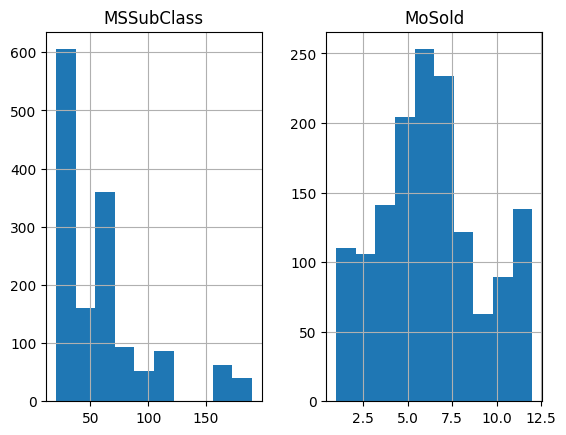

In [221]:
nominal_df.hist()
plt.show()

In [230]:
imbalanced_object

{'Condition1': 'Collapse very rare categories (<= 5 obs) into "other"',
 'Condition2': 'Collapse into "Norm" vs "Other"',
 'SaleCondition': 'collapse Adjland, alloca, and family into other',
 'GarageType': 'collapse less than 10 into other',
 'SaleType': 'Collapse less than 10 into other',
 'Exterior2nd': 'combine less than and combine Wd Sdng and Wd Shng',
 'Exterior1st': 'combine less than and combine Wd Sdng and Wd Shng',
 'RoofMatl': 'collapse into other all except CompShg and WdShngl',
 'RoofStyle': 'keep Gambrel and Hip, collapse others into other',
 'heating': 'keep GasA and GasW, collapse others into other',
 'Foundation': 'collapse stone and wood into others',
 'Electrical': 'collapse FusP and Mix'}

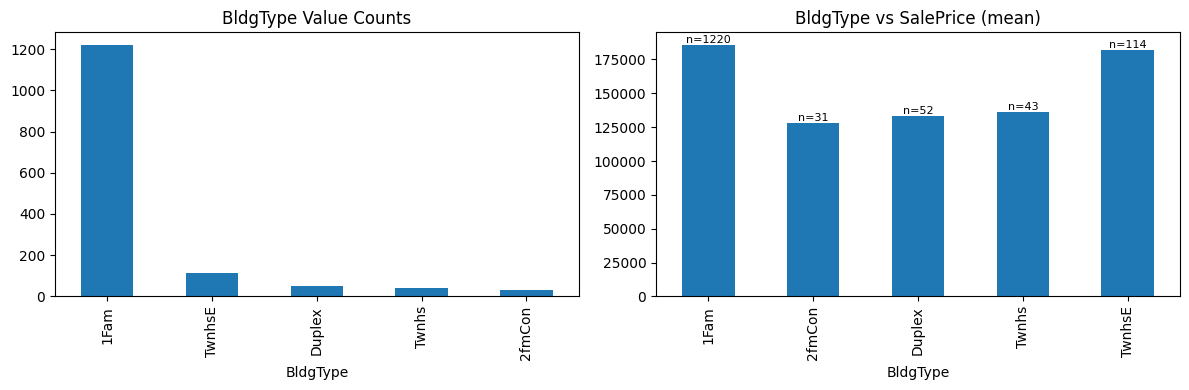

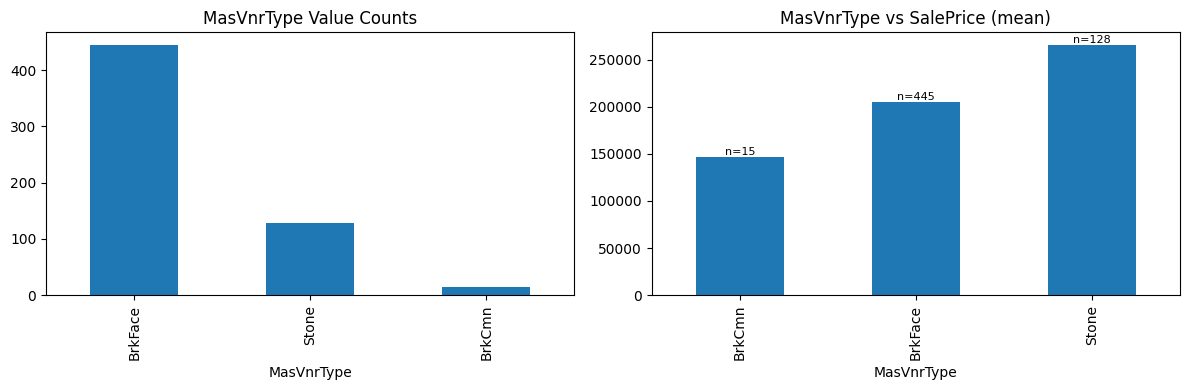

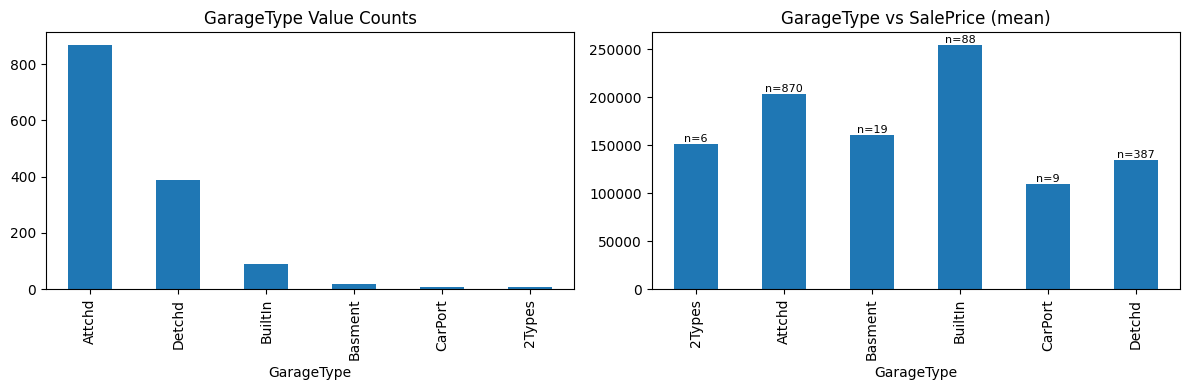

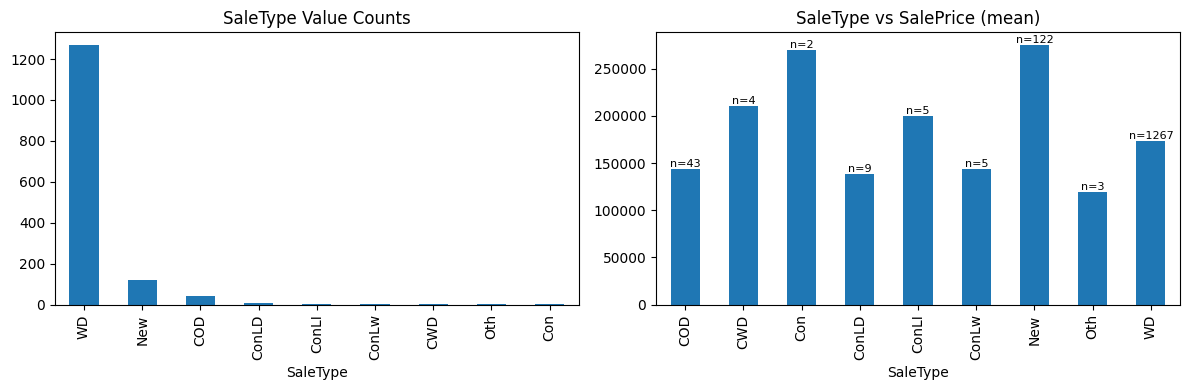

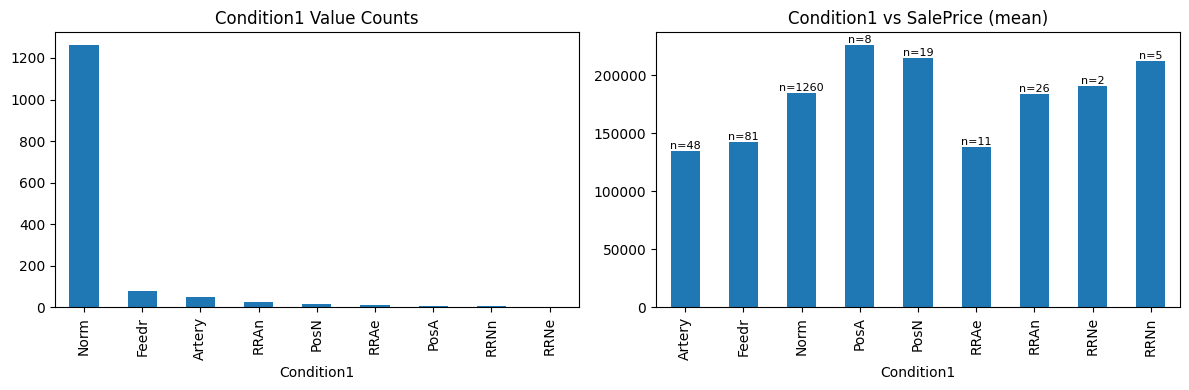

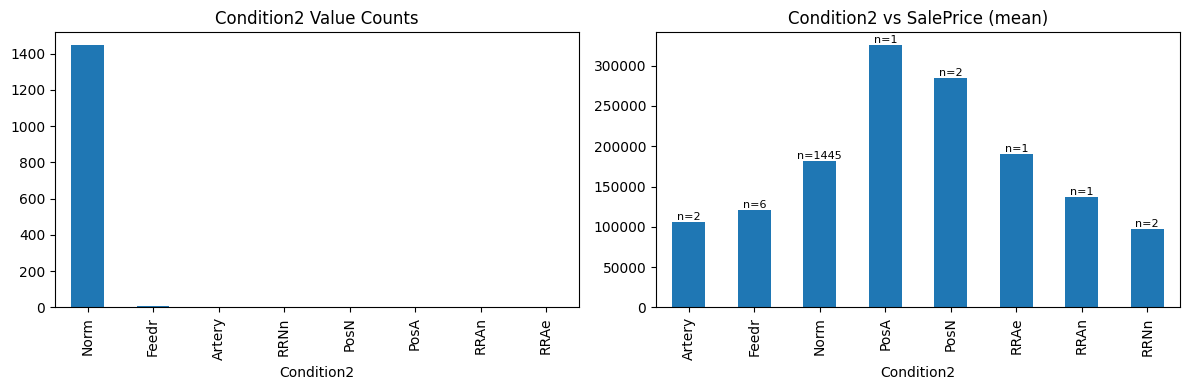

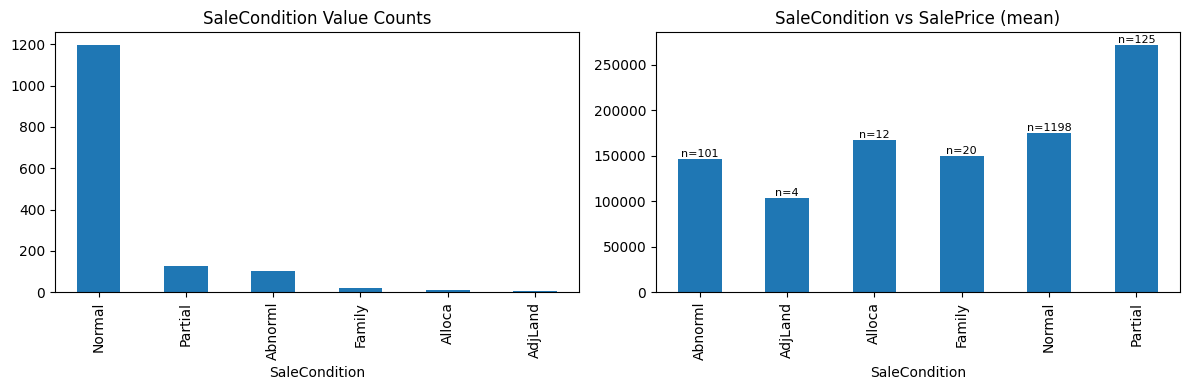

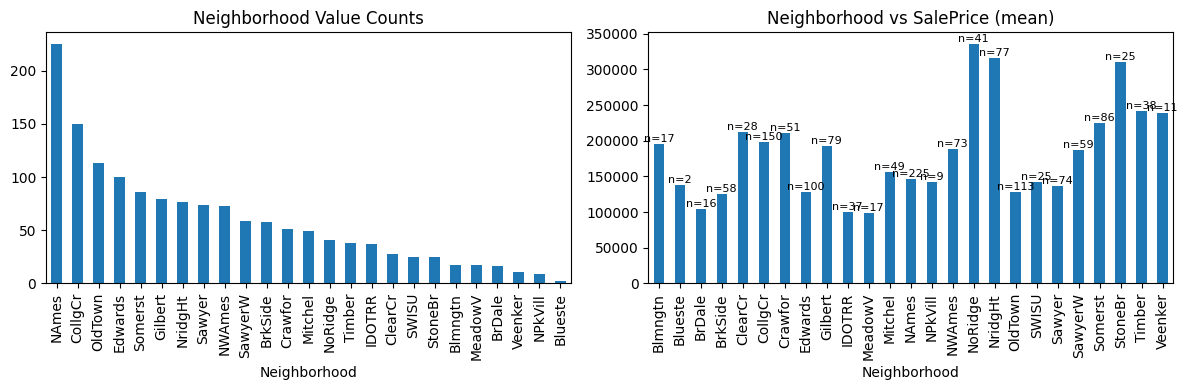

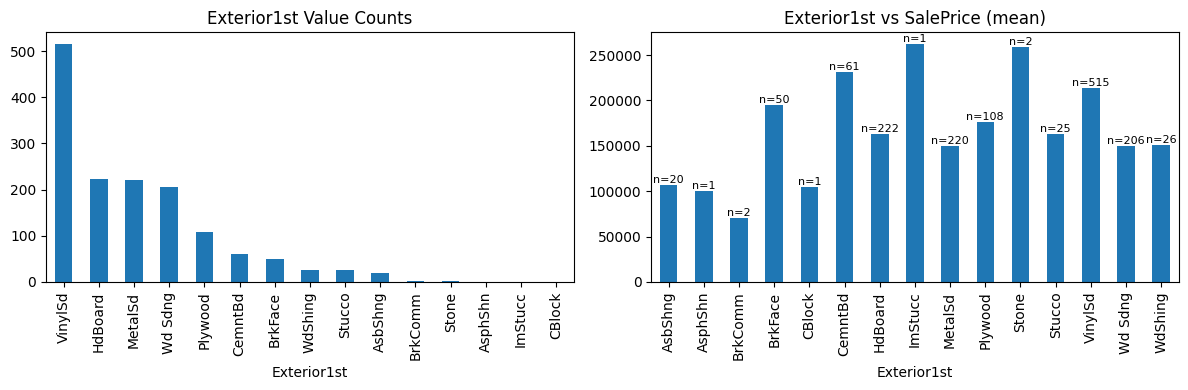

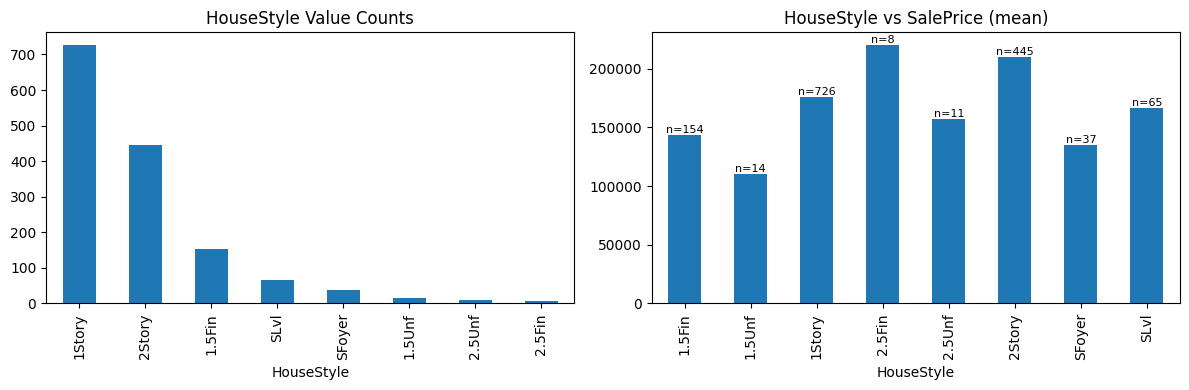

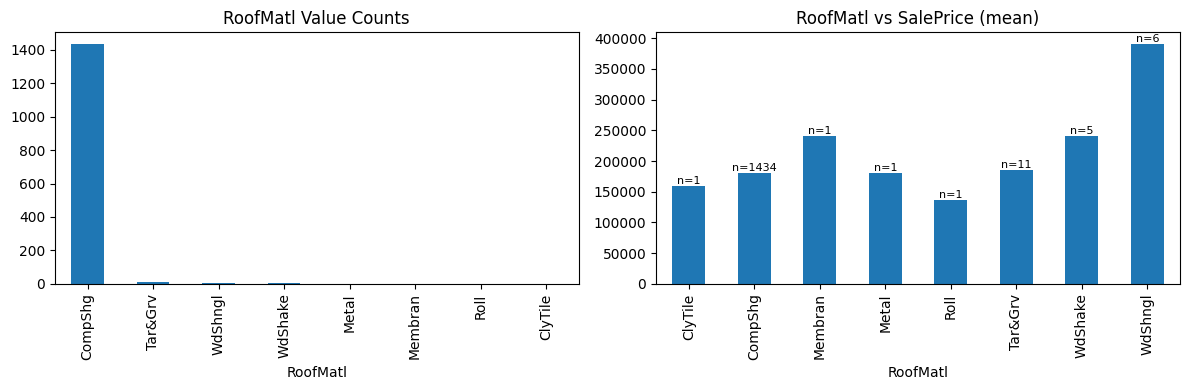

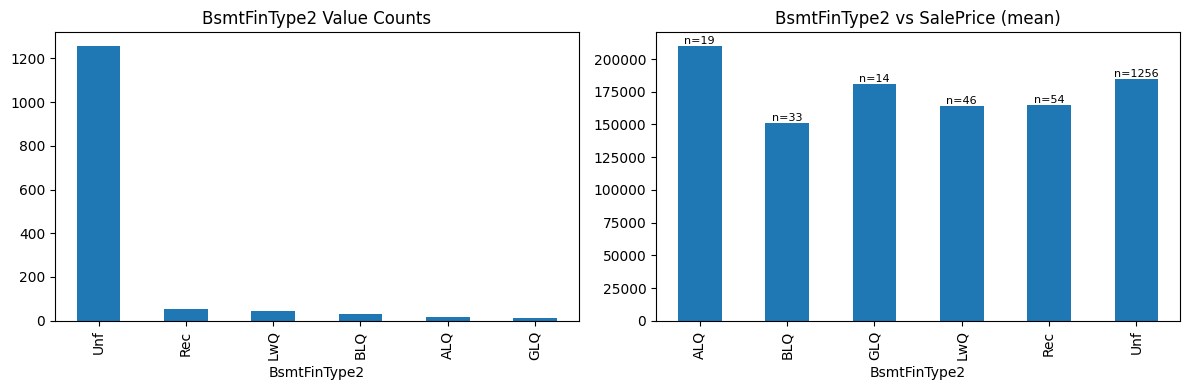

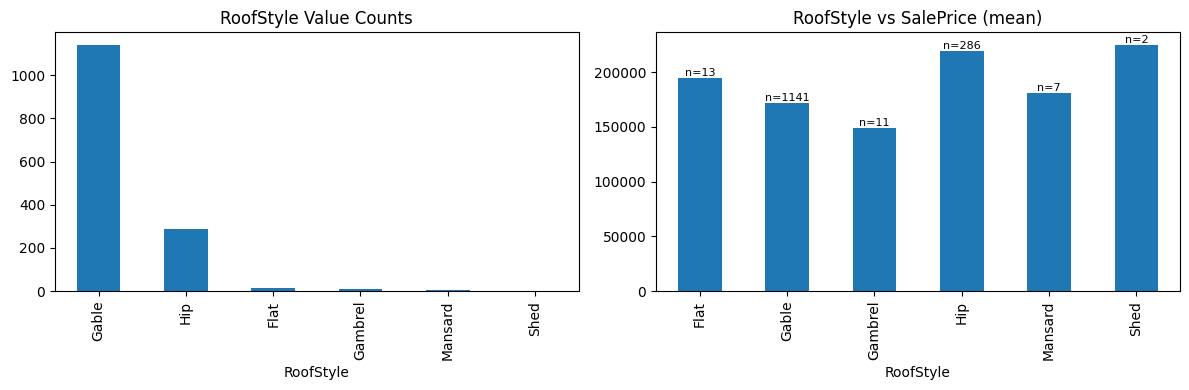

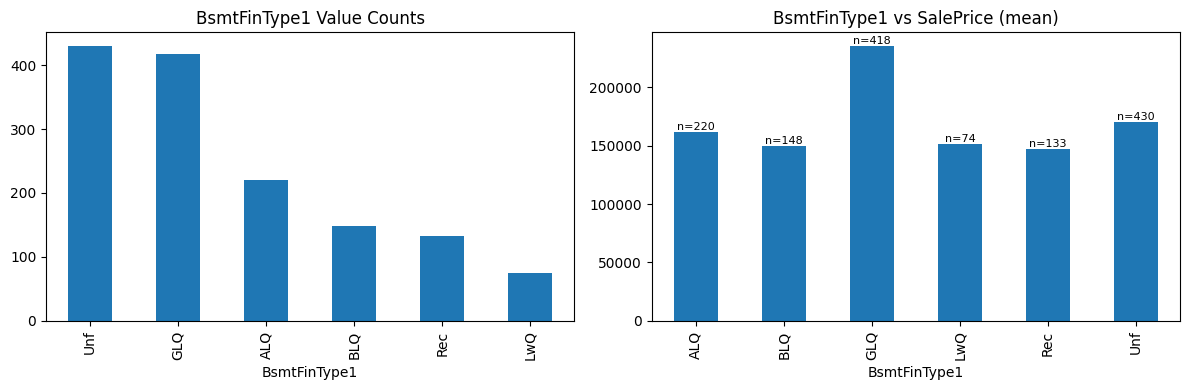

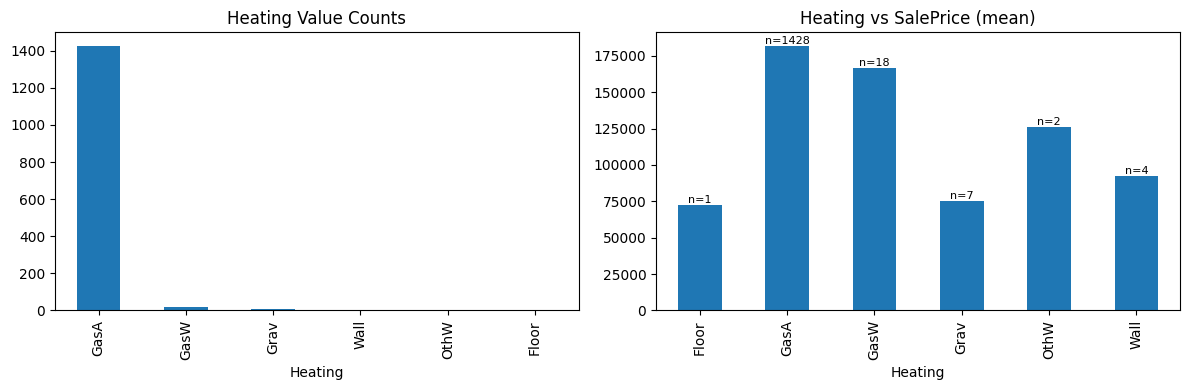

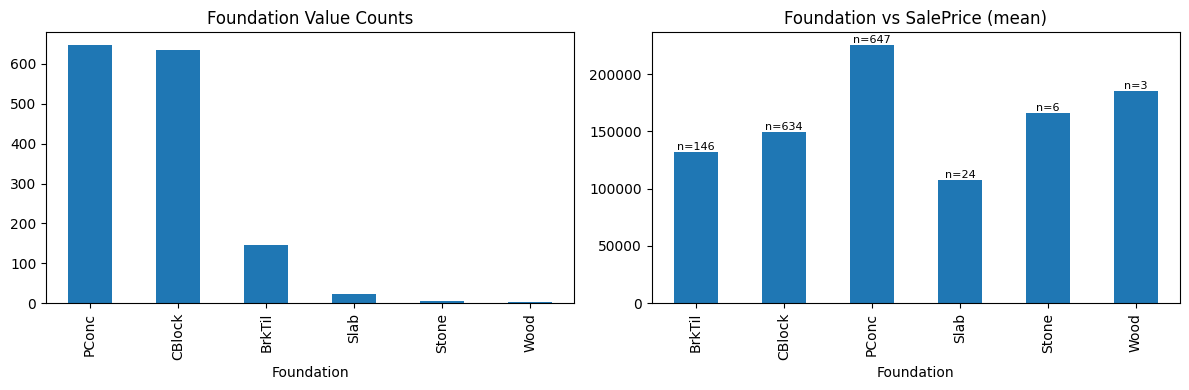

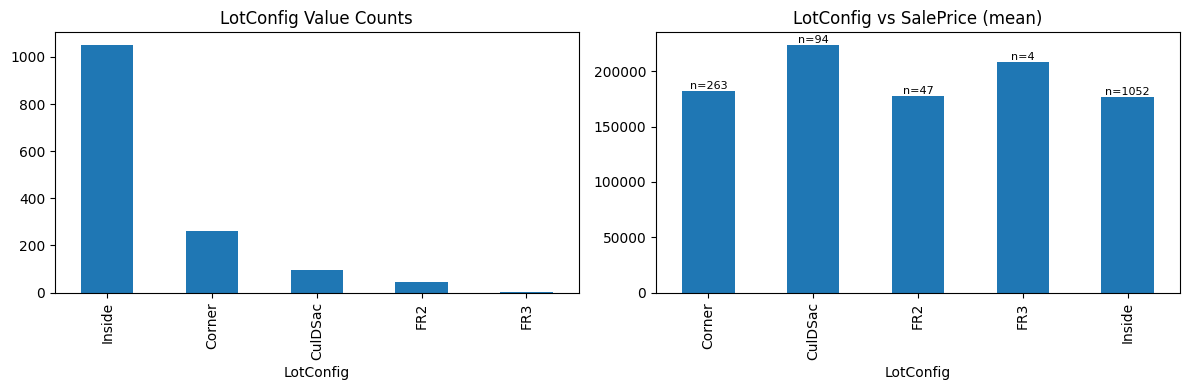

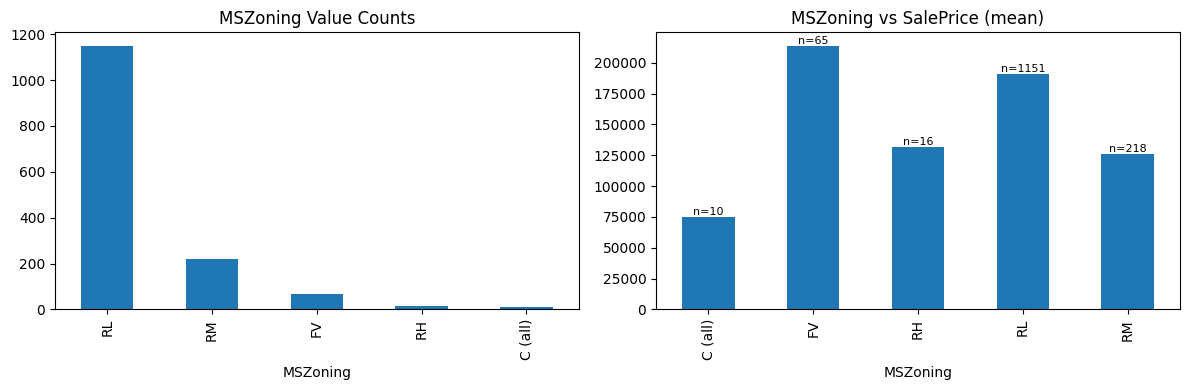

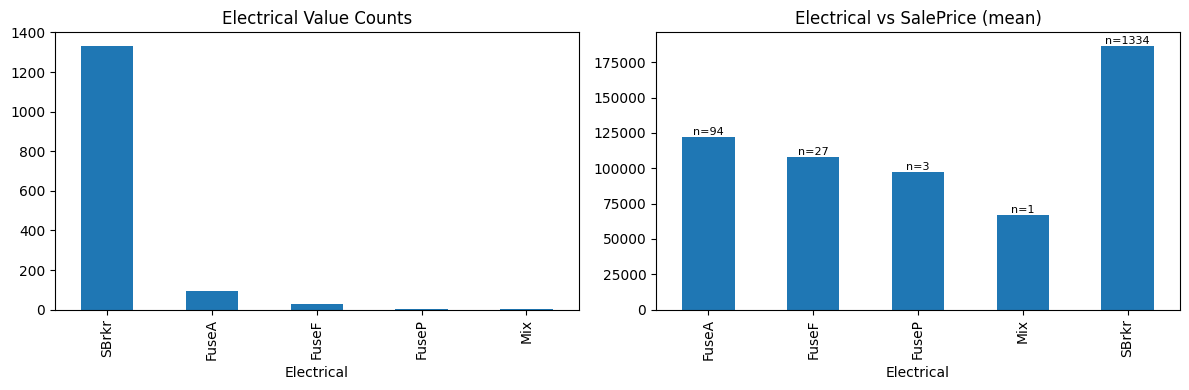

In [229]:
for col in nominal_df.select_dtypes(include='object').columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left → category counts
    nominal_df[col].value_counts().plot(kind='bar', ax=axes[0])
    axes[0].set_title(f"{col} Value Counts")

    # Right → target by category
    agg = (train_eda.groupby(col)["SalePrice"]
                     .agg(['mean','count'])
                     .rename(columns={'mean':'target_mean'}))
    agg['target_mean'].plot(kind='bar', ax=axes[1])
    axes[1].set_title(f"{col} vs SalePrice (mean)")

    # Annotate counts on top of bars (like in your function)
    for i, (val, n) in enumerate(zip(agg['target_mean'], agg['count'])):
        axes[1].text(i, val, f'n={n}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

In [234]:
for i, k in lists_dict.items():
    print(i, k)

nominal_cols ['MSSubClass', 'MoSold', 'BldgType', 'MasVnrType', 'GarageType', 'SaleType', 'Condition1', 'Condition2', 'SaleCondition', 'Neighborhood', 'Exterior1st', 'HouseStyle', 'RoofMatl', 'BsmtFinType2', 'RoofStyle', 'BsmtFinType1', 'Heating', 'Foundation', 'LotConfig', 'MSZoning', 'Electrical']
collapse_to_binary_cols ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'Fence']
right_skewed_cols ['LotArea', 'GrLivArea', 'BsmtUnfSF', 'SalePrice', '1stFlrSF', 'TotalBsmtSF', 'LotFrontage']
skewed_and_binary ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']
drop ['PoolQC', 'MiscFeature', 'Utilities', 'Id', 'GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']
obj_ordinal_cols ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'Functional', 'LandContour', 'LotShape', 'BsmtExposure', 'LandSlope', 'GarageFinish', 'PavedDri

In [235]:
lists_dict

{'nominal_cols': ['MSSubClass',
  'MoSold',
  'BldgType',
  'MasVnrType',
  'GarageType',
  'SaleType',
  'Condition1',
  'Condition2',
  'SaleCondition',
  'Neighborhood',
  'Exterior1st',
  'HouseStyle',
  'RoofMatl',
  'BsmtFinType2',
  'RoofStyle',
  'BsmtFinType1',
  'Heating',
  'Foundation',
  'LotConfig',
  'MSZoning',
  'Electrical'],
 'collapse_to_binary_cols': ['LowQualFinSF',
  'MiscVal',
  '3SsnPorch',
  'PoolArea',
  'BsmtFullBath',
  'HalfBath',
  'BsmtHalfBath',
  'BsmtFinSF2',
  'EnclosedPorch',
  'ScreenPorch',
  'Fence'],
 'right_skewed_cols': ['LotArea',
  'GrLivArea',
  'BsmtUnfSF',
  'SalePrice',
  '1stFlrSF',
  'TotalBsmtSF',
  'LotFrontage'],
 'skewed_and_binary': ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea'],
 'drop': ['PoolQC',
  'MiscFeature',
  'Utilities',
  'Id',
  'GarageArea',
  'TotRmsAbvGrd',
  'Alley',
  'Exterior2nd'],
 'obj_ordinal_cols': ['ExterQual',
  'ExterCond',
  'BsmtQual',
  'BsmtCond',
  'HeatingQC',
  'KitchenQual',
  'FireplaceQ

🏠 Size & Area Features

TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF → overall living + basement size.

PorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch → one combined porch measure.

TotalBaths = FullBath + HalfBath*0.5 + BsmtFullBath + BsmtHalfBath*0.5 → cleaner bathroom measure.

BasementPct = TotalBsmtSF / TotalSF → proportion of house that’s basement.

LotRatio = GrLivArea / LotArea → density of construction.

AvgRoomSize = GrLivArea / TotRmsAbvGrd (even if you drop TotRmsAbvGrd, this ratio is useful).

⏳ Time-Based Features

Use YrSold as reference:

HouseAge = YrSold – YearBuilt → age of the house at sale.

RemodAge = YrSold – YearRemodAdd → how long since last remodel.

GarageAge = YrSold – GarageYrBlt (clip negatives to 0).

IsRemodeled = binary flag if YearBuilt != YearRemodAdd.

DecadeBuilt = (YearBuilt // 10) * 10 → bin into decades.

🚪 Garage & Basement Features

HasGarage = from GarageType / GarageCars > 0.

GarageCapacityPerSF = GarageCars / GrLivArea → relative size.

FinishedBsmtPct = (TotalBsmtSF - BsmtUnfSF) / TotalBsmtSF → % finished basement.

HasBasement = binary if TotalBsmtSF > 0.

🏡 Location & Lot Features

CornerLot = flag from LotConfig == 'Corner'.

LotFrontageRatio = LotFrontage / LotArea → shape measure.

Neighborhood_Tier = group neighborhoods by median SalePrice (high/med/low tier).

MSSubClass_Category = map MSSubClass codes into meaningful categories (e.g., “1-Story,” “2-Story,” “Split Level”).

🔥 Quality / Condition Interactions

OverallQualityIndex = combine OverallQual (numeric) + OverallCond (ordinal) → more stable quality measure.

ExterScore = mean of ExterQual + ExterCond.

GarageScore = mean of GarageQual + GarageCond.

KitchenScore = just KitchenQual, or combine with Functional.

QualityAgeInteraction = OverallQual * HouseAge → newer but poor-quality vs. older but well-built.

⚡ Utility / Convenience Flags

HasCentralAir = from CentralAir.

Has2ndFlr = binary if 2ndFlrSF > 0.

HasPorch = binary if PorchSF > 0.

HasWoodDeck = binary if WoodDeckSF > 0.

HasMasonryVeneer = binary if MasVnrArea > 0.

🎯 Interaction Ideas (cross-bucket)

Size × Neighborhood: a big house in a low-value neighborhood doesn’t increase price as much as in a high-value one. Could be modeled with interaction terms.

Quality × Area: OverallQual * GrLivArea → large but poor-quality homes might not price the same as smaller but high-quality ones.

Condition × YearBuilt: newer homes in “adjacent to positive feature” conditions might be premium.